# Predicting Stolen Base Attempts and Successes

Author: Enikő Gergely <br>
Date: July, 2023

#### Introduction
In this notebook I will build a model that can predict the probability of a successful stolen base given that the runner takes off for an empty second base. Once the probabilities are available, they can be used to decide whether to attempt a base steal or not. Using the run values the percentage value can be calculated when it is a good tactic to steal in that situation and if the predicted probability is higher the runner can go for it or a steal can be expected by the defensive team.

In [1]:
## data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# machine learning
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, log_loss, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm #, , datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_selection import RFECV, SelectFromModel,  RFE, SelectKBest, chi2
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# pybaseball
!pip install pybaseball
import pybaseball as bb

#import data to pandas dataframe
df_metrics= pd.read_csv('StealPlayMetrics.csv')
df_context= pd.read_csv('StealContext.csv')



In [104]:
# Confusion matrix, normalized confusion matrix used for model evaluation
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels([0, 1])] 
    classes = classes.index.tolist()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.figure(figsize=(1,1))
    fig, ax = plt.subplots()
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def catcher_name(line):
    list_of_words = line.split()
    if [ index for index, item in enumerate(list_of_words) if item.lower() == 'catcher']:
        catcher_pos = [ index for index, item in enumerate(list_of_words) if item.lower() == 'catcher'][0]
        catcher_name = list_of_words[catcher_pos + 1]  + ' ' + list_of_words[catcher_pos + 2]
        catcher_name = catcher_name.replace(".", "")
    else:
        catcher_name = pd.NA
    return catcher_name

def pitcher_included(line):
    list_of_words = line.split()
    if [ index for index, item in enumerate(list_of_words) if item.lower() == 'pitcher']:
        pitcher_pos = [ index for index, item in enumerate(list_of_words) if item.lower() == 'pitcher'][0]
        pitcher_name = list_of_words[pitcher_pos + 1]  + ' ' + list_of_words[pitcher_pos + 2]
        pitcher_name = pitcher_name.replace(".", "")
    else:
        pitcher_name = pd.NA
    if pd.isnull(pitcher_name)== False:
        return 1
    else:
        return 0
    
def acc_and_f1(model, features_train_1):
    acc = np.round(np.mean(cross_val_score(model, features_train_1, labels_train, scoring = 'accuracy', cv = 10)), 5)
    f1 = np.round(np.mean(cross_val_score(model, features_train_1, labels_train, scoring = 'f1', cv = 10)), 5)
    return acc, f1

def try_classifiers(features_train):
    #Logistic regression
    clf = LogisticRegression(random_state= 42, solver = 'liblinear')
    LR = acc_and_f1(clf, features_train)

    #Naive Bayes:
    clfNB = GaussianNB()
    NB = acc_and_f1(clfNB, features_train)

    #SVM
    clfSVM = svm.SVC(gamma = 'auto')
    SVM = acc_and_f1(clfSVM, features_train)

    #RandomForest
    clfRF = RandomForestClassifier(n_estimators = 20, max_depth = 4)
    RF = acc_and_f1(clfRF, features_train)

    #Decision Tree
    clfDT = DecisionTreeClassifier()
    DT = acc_and_f1(clfDT, features_train)

    # Gradient Boosted Tree:
    clfGB = GradientBoostingClassifier(n_estimators=50, max_depth = 4 )
    GB = acc_and_f1(clfGB, features_train)

    # XGBoost
    clfXB = xgb.XGBClassifier(n_estimators=50)
    XB = acc_and_f1(clfXB, features_train)

    #summary table
    models = pd.DataFrame({
        'Model': ['Support Vector Machines', 'Logistic Regression', 'Gradient Boosting' , 
                  'Random Forest', 'Naive Bayes',  
                  'Decision Tree', 'XGBoost'],
        'Score': [SVM[0],  LR[0],  GB[0],
                  RF[0], NB[0], DT[0], XB[0]],
        'f1': [SVM[1], LR[1], GB[1],
                  RF[1], NB[1], DT[1], XB[1]]})


    return models.sort_values(by="f1" , ascending = False)

def model_evaluation(clf, features_train, features_test):
    clf.fit(features_train, labels_train)

    pred = clf.predict(features_test)
    proba = clf.predict_proba(features_test)
    proba = proba[:,1]


    #confusion matrix and other metrics
    cm = confusion_matrix(labels_test, pred)

    print("Accurary:" , accuracy_score(pred, labels_test))
    print("Accurary on train:" , accuracy_score(clf.predict(features_train), labels_train))
    print( "f1 score:" , f1_score(labels_test,pred))
    #calculate logloss
    print("logloss:", log_loss(labels_test, proba))

    #by elements
    log_likelihood_elements = labels_test * np.log(proba) + (1- labels_test)*np.log(1-proba)
    #-log_likelihood_elements.sum()/len(labels_test)

    print(classification_report(labels_test,pred))

    #plot confusion matrix
    classes = steal_2b.Advance #[CS, SB]
    plot_confusion_matrix(labels_test, pred, classes,
                              normalize=False)
    plot_confusion_matrix(labels_test, pred, classes,
                              normalize=True)
    
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, 
                        n_jobs = 1,  train_sizes = np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes, scoring = "f1") #neg_log_loss
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

In [3]:
df_metrics.columns

Index(['PlayGuid', 'RunnerId', 'PitcherId', 'CatcherId', 'Lead_Distance',
       'Secondary_Lead_Distance', 'Plate_Time_y0', 'Plate_Time_y17',
       'Pop_Time', 'PickOff_Steal_Exchange'],
      dtype='object')

In [4]:
df_context.columns

Index(['AwayTeam', 'HomeTeam', 'GameTime', 'Inning', 'InningTop',
       'VisitingScore', 'HomeScore', 'Balls', 'Strikes', 'OutsBefore',
       'PitchHand', 'BatHand', 'BallparkId', 'PlayDescription',
       'PlayDetailType', 'PlayGuid', 'StartRunnerOnFirstId',
       'StartRunnerOnSecondId', 'StartRunnerOnThirdId', 'Advance',
       'ThrownOut'],
      dtype='object')

In [5]:
df_metrics.describe()

RunnerId      PitcherId      CatcherId  Lead_Distance  \
count    9856.000000    9444.000000    4579.000000    9856.000000   
mean   611930.997362  601674.966328  581812.365582      12.149601   
std     62682.442378   71136.121662   74813.257540       3.352367   
min    405395.000000  282332.000000  425772.000000       0.174000   
25%    572816.000000  554430.000000  543265.000000      10.364750   
50%    622534.000000  607625.000000  595751.000000      11.283500   
75%    664913.000000  663465.000000  643376.000000      12.878500   
max    702478.000000  702914.000000  703245.000000      43.900175   

       Secondary_Lead_Distance  Plate_Time_y0  Plate_Time_y17     Pop_Time  \
count              9567.000000   9.444000e+03     9443.000000  4579.000000   
mean                 22.028947   5.115243e+05        0.427672     1.981406   
std                   5.915969   4.971002e+07        0.031058     0.283641   
min                   0.759000  -5.990000e-01        0.366000     1.335000   
25%                  18.785500   4.140000e-01        0.403000     1.911500   
50%                  21.487000   4.320000e-01        0.420000     1.996000   
75%                  24.454000   4.600000e-01        0.448000     2.068000   
max                  66.286000   4.830832e+09        0.575000     6.441000   

       PickOff_Steal_Exchange  
count             4314.000000  
mean                 0.765766  
std                  0.241835  
min                  0.198000  
25%                  0.686000  
50%                  0.732000  
75%                  0.783000  
max                  5.182000

In [6]:
df_context.describe()

Inning    InningTop  VisitingScore    HomeScore        Balls  \
count  7356.000000  7356.000000    7356.000000  7356.000000  7356.000000   
mean      4.789152     0.512779       2.106172     2.025150     0.867727   
std       2.659973     0.499871       2.199378     2.181136     0.940681   
min       1.000000     0.000000       0.000000     0.000000     0.000000   
25%       3.000000     0.000000       0.000000     0.000000     0.000000   
50%       5.000000     1.000000       2.000000     1.000000     1.000000   
75%       7.000000     1.000000       3.000000     3.000000     1.000000   
max      18.000000     1.000000      15.000000    14.000000     3.000000   

           Strikes   OutsBefore   BallparkId  StartRunnerOnFirstId  \
count  7356.000000  7356.000000  7356.000000           6812.000000   
mean      0.954459     1.198341    44.969549         598427.765120   
std       0.833831     0.761195    88.574683          59425.408873   
min       0.000000     0.000000     1.000000         405395.000000   
25%       0.000000     1.000000     8.000000         566190.250000   
50%       1.000000     1.000000    18.000000         606466.000000   
75%       2.000000     2.000000    50.000000         645277.000000   
max       2.000000     2.000000   412.000000         683734.000000   

       StartRunnerOnSecondId  StartRunnerOnThirdId      Advance    ThrownOut  
count             995.000000           1017.000000  7356.000000  7356.000000  
mean           593691.086432         590993.006883     0.699701     0.300299  
std             60436.276954          63566.775934     0.458419     0.458419  
min            405395.000000         405395.000000     0.000000     0.000000  
25%            544725.000000         543939.000000     0.000000     0.000000  
50%            605204.000000         600869.000000     1.000000     0.000000  
75%            643289.000000         642715.000000     1.000000     1.000000  
max            676480.000000         683734.000000     1.000000     1.000000

# Select relevant data only 
I will focus on the SB attempts to 2B when there is only a runner on first base. I will also remove pickoff attempts from the dataset, since those are different from steal attempts. 

Context and metrics data can be joined on 'PlayGuid'. There are 132 items in the context data that has no information in the metrics dataset. I will only look at items which are available in both datasets, otherwise we would be missing both pitcher, catcher and runner information. With imputation these rows would look the same which is not useful for the model.

In [7]:
# select items from context dataset where there is only runner on first base and it is a steal attempt to 2nd base (steal_2b)
df_runner_on_1st = df_context[(df_context['StartRunnerOnFirstId'].isnull() == False) 
                              & (df_context['StartRunnerOnSecondId'].isnull() == True) 
                              & (df_context['StartRunnerOnThirdId'].isnull() == True)
                              & (df_context['PlayDetailType']== 'steal_2b')]
print('Runner on first from context: ' , len(df_runner_on_1st))

# missing metrics data:
steal_2b_missing_metrics = df_runner_on_1st.merge(df_metrics, right_on = ['PlayGuid', 'RunnerId'],
             left_on = ['PlayGuid', 'StartRunnerOnFirstId'], how = 'left')
print('Missing metrics data for context:' , len(steal_2b_missing_metrics[steal_2b_missing_metrics['RunnerId'].isnull()]))

# add metrics to context data
# only keep data where there is data from metrics
# otherwise both runner, pitcher and catcher info is missing, not useful for modelling
steal_2b =  df_runner_on_1st.merge(df_metrics, right_on = ['PlayGuid', 'RunnerId'],
             left_on = ['PlayGuid', 'StartRunnerOnFirstId'], how = 'inner')
print('Runner on first both in context and metrics: ' , len(steal_2b))

Runner on first from context:  4838
Missing metrics data for context: 132
Runner on first both in context and metrics:  4706


### Metrics Data and outliers
I visualized the metrics data columns and their relationship for catchers (Pop_Time, PickOff_Steal_Exchange), runners (Lead_Distance, Secondary_lead_distance) and pitchers (Plate_Time_y0, Plate_time_y17 )

There are several outliers that need to be checked:
 - Pop_Time > 3.5 or PickOff_Steal_Exchange> 2
 -  Lead_Distance > 25 or < 5
 - Plate_time_y0 > 1, maybe plate_time_y17 > 0.550


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


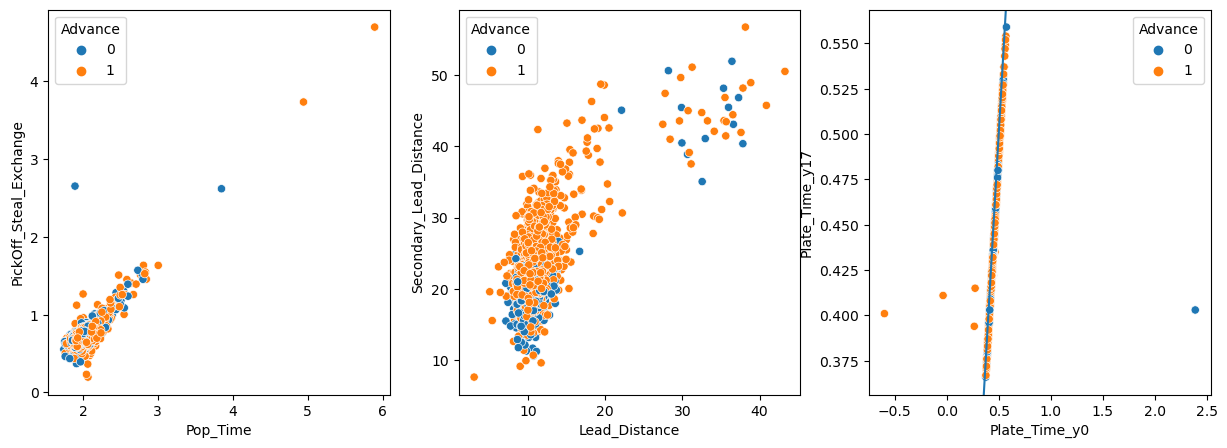

In [8]:
# look at the values from the metrics dataset: 
fig, axs = plt.subplots(1, 3, figsize = (15,5))
print(axs)
sns.scatterplot(x="Pop_Time", y="PickOff_Steal_Exchange",  data=steal_2b, ax=axs[0], hue = 'Advance')
sns.scatterplot(x="Lead_Distance", y="Secondary_Lead_Distance",  data=steal_2b, ax=axs[1], hue = 'Advance')
sns.scatterplot(x="Plate_Time_y0", y="Plate_Time_y17",  data=steal_2b , ax=axs[2], hue= 'Advance')
plt.axline([0.4, 0.4], slope=1)

#### Analyize Pop Time and Exchange strange values:

In [9]:
# see items:
steal_2b[steal_2b['PickOff_Steal_Exchange'] > 2]

AwayTeam HomeTeam             GameTime  Inning  InningTop  VisitingScore  \
851       STL      CHC  2019-06-09 18:05:00       4          1              1   
1068      BAL       TB  2019-07-01 19:10:00       5          1              1   
1564      PHI      BOS  2019-08-20 19:10:00       9          1              3   
2112      OAK      SEA  2020-08-02 13:10:00       6          1              3   

      HomeScore  Balls  Strikes  OutsBefore  ... ThrownOut RunnerId  \
851           1      0        1           1  ...         1   542303   
1068          2      2        0           0  ...         1   542340   
1564          2      1        2           2  ...         0   656514   
2112          1      0        2           1  ...         0   592192   

      PitcherId CatcherId Lead_Distance Secondary_Lead_Distance  \
851    543294.0  575929.0        10.693                  10.599   
1068   642232.0  572287.0        10.853                  15.313   
1564   598264.0  543877.0        10.532                  22.531   
2112   664948.0  621529.0        10.150                  19.985   

      Plate_Time_y0  Plate_Time_y17  Pop_Time  PickOff_Steal_Exchange  
851           0.495           0.482     1.894                   2.653  
1068          0.461           0.449     3.849                   2.619  
1564          0.448           0.436     4.944                   3.734  
2112          0.447           0.435     5.894                   4.697  

[4 rows x 30 columns]

In [10]:
# see their Description:
list(steal_2b[steal_2b['PickOff_Steal_Exchange'] > 2]['PlayDescription'])

['Marcell Ozuna caught stealing 2nd base, catcher Willson Contreras to shortstop Javier Baez.  ',
 'Orioles challenged (tag play), call on the field was upheld: Jonathan Villar caught stealing 2nd base, catcher Mike Zunino to second baseman Brandon Lowe.  ',
 'Andrew Knapp strikes out swinging.   Andrew Knapp to 1st.  Adam Haseley steals (2) 2nd base.   Andrew Knapp to 1st.  Wild pitch by pitcher Matt Barnes.  ',
 'Mark Canha steals (1) 2nd base.  Mark Canha out at 3rd, catcher Joe Hudson to third baseman Dylan Moore.  ']

Wild pitches could be excluded from the population. For now I just remove the values in PickOff_Steal_Exchange and Pop_Time columns and impute later, and keep their rows.


In [11]:
# remove values, set them to null:
steal_2b.loc[steal_2b['PickOff_Steal_Exchange'] > 2, 'PickOff_Steal_Exchange']= np.nan
steal_2b.loc[steal_2b['Pop_Time'] > 3.5, 'Pop_Time']= np.nan

#### Analyize Lead and Secondary Lead strange values:

Looking at the video of some examples of Lead_Distance > 25  and Lead_Distance < 5 it seems those are likely to be data issues, so I remove them all.

In [12]:
print('Before:', len(steal_2b))
steal_2b = steal_2b[(steal_2b['Lead_Distance']> 5) & (steal_2b['Lead_Distance']< 25)]
print('After:', len(steal_2b))

Before: 4706
After: 4670


#### Analyize Plate Time strange values:

Since Plate_Time_y17 and Plate_Time_y0 has a linear relationship. The values seems to be off in Plate_Time_y0. Set Plate_time_y0 as Plate_Time_y17 + mean difference between y0 and y17.

In [13]:
# mean difference:
plate_time_mean_dif = (steal_2b['Plate_Time_y0']-steal_2b['Plate_Time_y17']).mean()

# update 
steal_2b.loc[steal_2b['Plate_Time_y0'] > 1,'Plate_Time_y0'] = steal_2b.loc[steal_2b['Plate_Time_y0'] > 1,'Plate_Time_y17'] + plate_time_mean_dif
steal_2b.loc[steal_2b['Plate_Time_y0'] < 0.3,'Plate_Time_y0'] = steal_2b.loc[steal_2b['Plate_Time_y0'] < 0.3,'Plate_Time_y17'] + plate_time_mean_dif

#### Results:

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


<AxesSubplot:xlabel='Plate_Time_y0', ylabel='Plate_Time_y17'>

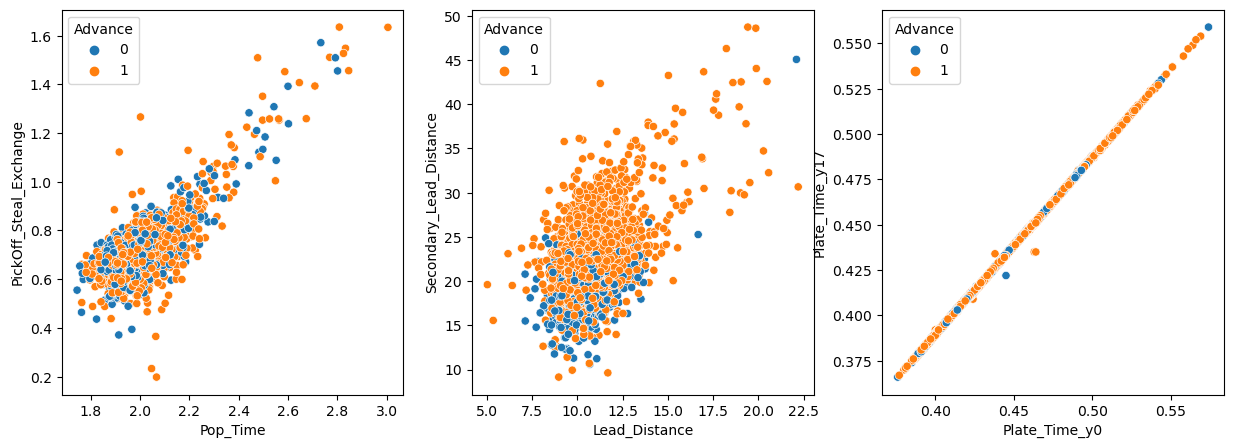

In [14]:
# check all results :
# look at the values from the metrics dataset: 
fig, axs = plt.subplots(1, 3, figsize = (15,5))
print(axs)
sns.scatterplot(x="Pop_Time", y="PickOff_Steal_Exchange",  data=steal_2b, ax=axs[0], hue = 'Advance')
sns.scatterplot(x="Lead_Distance", y="Secondary_Lead_Distance",  data=steal_2b, ax=axs[1], hue = 'Advance')
sns.scatterplot(x="Plate_Time_y0", y="Plate_Time_y17",  data=steal_2b , ax=axs[2], hue= 'Advance')

#### Play Description analysis
Exclude wild pitch plays and where pitcher is included in the play. In those cases it is either a wild pitch but given as stolen base to the runner or there is no pitch to catcher, but directly to 2nd from the pitcher. Stolen base on a wild pitch is a decision of the official scorer, so I decided to exclude. 

In [15]:
# get flag for rows where pitcher is included in the play
steal_2b['Is_Pitcher_included'] = steal_2b['PlayDescription'].apply(lambda x: pitcher_included(x))

In [16]:
# see descriptions:
pd.set_option('max_colwidth', 1000)
steal_2b[steal_2b['Is_Pitcher_included'] == 1][['PlayDescription']].drop_duplicates()

PlayDescription
671                                          Nick Ahmed steals (3) 2nd base.   Nick Ahmed to 3rd.  Wild pitch by pitcher Shaun Anderson.   Nick Ahmed to 3rd.  
747                                                               Brian Anderson caught stealing 2nd base, pitcher Adam Warren to second baseman Ian Kinsler.  
766                                                                   Rhys Hoskins caught stealing 2nd base, pitcher Luis Perdomo to shortstop Manny Machado.  
1117   Nelson Cruz strikes out swinging.   Nelson Cruz to 1st.  Wild pitch by pitcher Jose Leclerc.   Nelson Cruz to 1st.  Jorge Polanco steals (4) 2nd base.  
1345                                                             Alex Verdugo caught stealing 2nd base, pitcher Kyle Freeland to second baseman Ryan McMahon.  
1564  Andrew Knapp strikes out swinging.   Andrew Knapp to 1st.  Adam Haseley steals (2) 2nd base.   Andrew Knapp to 1st.  Wild pitch by pitcher Matt Barnes.  
1710            Nick Ahmed caught stealing 2nd base, pitcher Craig Stammen to second baseman Ty France to first baseman Eric Hosmer to shortstop Greg Garcia.  
1930                                                         Josh Rojas caught stealing 2nd base, pitcher Daniel Ponce de Leon to second baseman Tommy Edman.  
2784                              Billy Hamilton steals (6) 2nd base.   Billy Hamilton to 3rd.  Wild pitch by pitcher Jimmy Cordero.   Billy Hamilton to 3rd.  
2870                                 Ryan McMahon steals (1) 2nd base.   Ryan McMahon to 3rd.  Wild pitch by pitcher Anthony DeSclafani.   Ryan McMahon to 3rd.
3625                                                                   Anthony Rizzo caught stealing 2nd base, pitcher Zach Thompson to shortstop Miguel Rojas.
3733                          Tommy Edman steals (14) 2nd base.   Tommy Edman to 3rd.  Tommy Edman advances to 3rd, on a throwing error by pitcher Caleb Smith.
3928                                 Rhys Hoskins caught stealing 2nd base, pitcher Aroldis Chapman to first baseman Chris Gittens to shortstop Gleyber Torres.
4242                                  Manuel Margot steals (11) 2nd base.   Manuel Margot to 3rd.  Wild pitch by pitcher Craig Kimbrel.   Manuel Margot to 3rd.
4511                              Matt Duffy steals (6) 2nd base.   Matt Duffy to 3rd.  Matt Duffy advances to 3rd, on a throwing error by pitcher Aaron Ashby.

In [17]:
# remove all where pitcher is included in the play
print('Before:', len(steal_2b))
steal_2b = steal_2b[steal_2b['Is_Pitcher_included'] == 0]
print('After:', len(steal_2b))

Before: 4670
After: 4655


### SB and CS count

Number of CS:  1163
Number of SB:  3492
Average Success Rate:  75.02 %


C:\Users\eniko\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


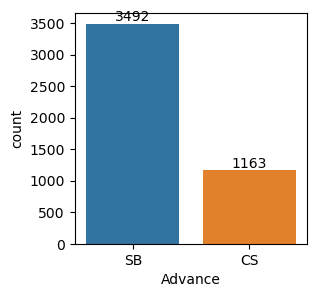

In [18]:
#show number of SB (Advance = 1) and CS (Advance = 0)
plt.figure(figsize= (3,3))
ax=sns.countplot(steal_2b["Advance"].apply(lambda x: 'CS' if x == 0 else 'SB'), label="Count")
ax.bar_label(ax.containers[0])
SB, CS = steal_2b["Advance"].value_counts()
print('Number of CS: ', CS)
print('Number of SB: ', SB)
print ('Average Success Rate: ' , round(SB/(CS+SB)*100, 2), '%')

# Add new columns:
I will create some new columns from existing data or add new data from baseballsavant:
- lead_by_defense: from HomeScore and VisitingScore, shows the lead by the defensive team.
- Pitcher_is_left_handed: from PitchHand
- Batter_is_left_handed: from BatHand
- Lead_Difference: the difference between Secondary_Lead_Distance and Lead_Distance

- Catcher_Name_from_Description: get catcher name from play description, can be used for data imputation for missing catcher info

- sprint speed: average sprint speed of runner in the given year
- pitcher's arsenal: percentage usage of different pitch types
- armstrengh: average arm strengh for catcher by year (added later) 

In [19]:
#create new feature from VisitingScore and HomeScore to show defensive lead
steal_2b['lead_by_defense'] = np.where(steal_2b['InningTop'] == 1, 
                                       steal_2b['HomeScore']-steal_2b['VisitingScore'], 
                                       steal_2b['VisitingScore']- steal_2b['HomeScore'])

#create Pitcher_is_left_handed feature from PitchHand
steal_2b['Pitcher_is_left_handed'] = np.where(steal_2b['PitchHand'] == "L", 1, 0)

#create Batter_is_left_handed feature from BatHand
steal_2b['Batter_is_left_handed'] = np.where(steal_2b['BatHand'] == "L", 1, 0)

# create Lead_Difference from Secondary and initial lead distances
steal_2b['Lead_Difference'] = steal_2b['Secondary_Lead_Distance'] - steal_2b['Lead_Distance']

# get Catcher name nad Pitcher name from paly description
steal_2b['Catcher_Name_from_Description'] = steal_2b['PlayDescription'].apply(lambda x: catcher_name(x))

# year:
steal_2b['Year'] = steal_2b['GameTime'].apply(lambda x: x[0:4]).astype(str).astype(int)

In [20]:
# merge back catcherId 
# create catcher name and id df from description data
catcher_name_and_id = steal_2b[(steal_2b['Catcher_Name_from_Description'].isnull() == False)& 
                               (steal_2b['CatcherId'].isnull() == False)][['Catcher_Name_from_Description', 'CatcherId']].drop_duplicates()

steal_2b = steal_2b.merge(catcher_name_and_id, on = 'Catcher_Name_from_Description' , how = 'left', suffixes=('', '_from_Description'))
steal_2b['CatcherIdAll'] = steal_2b['CatcherId'].fillna(steal_2b['CatcherId_from_Description'])

In [21]:
# imputed catcherIds:
print('Number of imputed Catcher Ids:', len(steal_2b[(steal_2b['CatcherId'].isnull()) & (steal_2b['CatcherIdAll'].isnull()== False)]))

Number of imputed Catcher Ids: 339


#### sprint speed

In [28]:
# get sprint speed info from statcast by year
speed_2019 =bb.statcast_sprint_speed(year= 2019, min_opp= 1).assign(Year=2019)
speed_2020 =bb.statcast_sprint_speed(year= 2020, min_opp= 1).assign(Year=2020)
speed_2021 =bb.statcast_sprint_speed(year= 2021, min_opp= 1).assign(Year=2021)
speed = pd.concat ([speed_2019, speed_2020, speed_2021]) 
speed.rename(columns = {'last_name, first_name': 'RunnerName'}, inplace = True)
#speed['RunnerName'] = speed['first_name'] + ' '+ speed['last_name']

In [29]:
speed.head()

RunnerName  player_id  team_id team position  age  competitive_runs  \
0   Locastro, Tim     641796      109   AZ       LF   26                91   
1    Turner, Trea     607208      120  WSH       SS   26               225   
2   Buxton, Byron     621439      142  MIN       CF   25                98   
3  Gore, Terrance     605253      118   KC       LF   28                23   
4    Quinn, Roman     596451      143  PHI       CF   26                38   

   bolts  hp_to_1b  sprint_speed  Year  
0   61.0      3.94          30.8  2019  
1  114.0      4.05          30.4  2019  
2   46.0      3.98          30.4  2019  
3   14.0       NaN          30.2  2019  
4   28.0      4.02          30.1  2019

In [30]:
# add speed to df
steal_2b = steal_2b.merge(speed[['player_id', 'Year', 'sprint_speed','RunnerName' ]], 
                      left_on = ['StartRunnerOnFirstId', 'Year'], 
                      right_on = ['player_id', 'Year'], how = 'left').drop(columns = ['player_id'],  axis = 1)


#### pitcher's arsenal 

In [31]:
# get the percentage share for each pitch by pitcher by year
arsenal_usage_2019 = bb.statcast_pitcher_pitch_arsenal(year = 2019, minP = 0, arsenal_type = "n_").assign(Year=2019)
arsenal_usage_2020 = bb.statcast_pitcher_pitch_arsenal(year = 2020, minP = 0, arsenal_type = "n_").assign(Year=2020)
arsenal_usage_2021 = bb.statcast_pitcher_pitch_arsenal(year = 2021, minP = 0, arsenal_type = "n_").assign(Year=2021) 

arsenal_usage = pd.concat([arsenal_usage_2019, arsenal_usage_2020, arsenal_usage_2021]) 
arsenal_usage.rename(columns = {'last_name, first_name': 'PitcherName'}, inplace = True)
#arsenal_usage['PitcherName'] = arsenal_usage['first_name'] + ' '+ arsenal_usage['last_name']

arsenal_usage = arsenal_usage.fillna(0)

In [32]:
arsenal_usage.head()

PitcherName  pitcher  n_ff  n_si  n_fc  n_sl  n_ch  n_cu  n_fs  \
0       Bauer, Trevor   545333  38.5   3.8  16.5   0.0   7.7  19.7   0.0   
1         Lynn, Lance   458681  54.1  17.2  16.2   0.0   3.0   9.5   0.0   
2  Strasburg, Stephen   544931  28.6  19.7   0.0   0.4  20.7  30.7   0.0   
3  Rodriguez, Eduardo   593958  38.6  15.6  16.3   2.1  24.1   3.3   0.0   
4        Cole, Gerrit   543037  51.6   2.4   0.0  23.2   7.4  15.4   0.0   

   n_kn  n_st  n_sv  Year  
0   0.0  13.9   0.0  2019  
1   0.0   0.0   0.0  2019  
2   0.0   0.0   0.0  2019  
3   0.0   0.0   0.0  2019  
4   0.0   0.0   0.0  2019

In [33]:
# merge to steal_2b
steal_2b = steal_2b.merge(arsenal_usage[['pitcher', 'Year', 'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs', 'n_kn', 'n_st', 'n_sv', 'PitcherName' ]], left_on = ['PitcherId', 'Year'], right_on = ['pitcher', 'Year'], how = 'left')

# Missing values
As a first step I remove the columns which won't be part of the analysis later like player information (id, names, team), date, game time, and some data which are not relevant.

Possible features:
- Inning,
- lead_by_defense,
- Balls,
- Strikes,
- OutsBefore,
- Pitcher_is_left_handed,
- Batter_is_left_handed,
- Pop_time,
- PickOff_Steal_Exchange,
- Lead_Distance,
- Secondary_Lead_distance,
- Lead_Difference,
- sprint_speed,
- Plate_Time_y0
- Plate_Time_y17
- pitcher arsenal : 'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs', 'n_kn', 'n_st', 'n_sv',


labels:
- Advance = steal_flag
- ThrownOut = cs_flag

In [36]:
features_initial = ['Inning', 'VisitingScore', 'HomeScore', 'lead_by_defense', 'Balls', 'Strikes', 'OutsBefore',
    'Pitcher_is_left_handed', 'Batter_is_left_handed', 
    'Pop_Time', 'PickOff_Steal_Exchange', 
    'Lead_Distance', 'Secondary_Lead_Distance',    'Lead_Difference',    'sprint_speed',    
    'Plate_Time_y0', 'Plate_Time_y17', 'n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs', 'n_kn', 'n_st', 'n_sv', 
    'Advance', 'ThrownOut']

In [37]:
# summary on missing values by IDs:
steal_2b[['RunnerId', 'CatcherId','CatcherIdAll', 'PitcherId']].isnull().value_counts()

RunnerId  CatcherId  CatcherIdAll  PitcherId
False     False      False         False        2708
          True       True          False        1581
                     False         False         339
                     True          True           27
dtype: int64

There are 
- 2708 rows with all Runner, Catcher and Picher Id available
- 1920 where catcher Id is missing but there is PitcherId
    - 339 catcherId was updated using play description - these can be imputed with catcher averages
    - the rest could be imputed with overall averages but there would be too many average values for catcher data that might hurt the model
- 27 with no catcher and pitcher ID 
    - these willbe removed

In [38]:
# keep only the ones where there is availbale id for all runner, catcher and pitcher
print('Number of rows before removal: ', len(steal_2b))
steal_2b = steal_2b[(steal_2b['RunnerId'].isnull() == False) & 
                    (steal_2b['CatcherIdAll'].isnull() == False) & 
                    (steal_2b['PitcherId'].isnull() == False)]
print('Final Rows after removal: ', len(steal_2b))

Number of rows before removal:  4655
Final Rows after removal:  3047


Pop_Time                  341
PickOff_Steal_Exchange    441
sprint_speed               11
n_ff                       34
n_si                       34
n_fc                       34
n_sl                       34
n_ch                       34
n_cu                       34
n_fs                       34
n_kn                       34
n_st                       34
n_sv                       34
dtype: int64


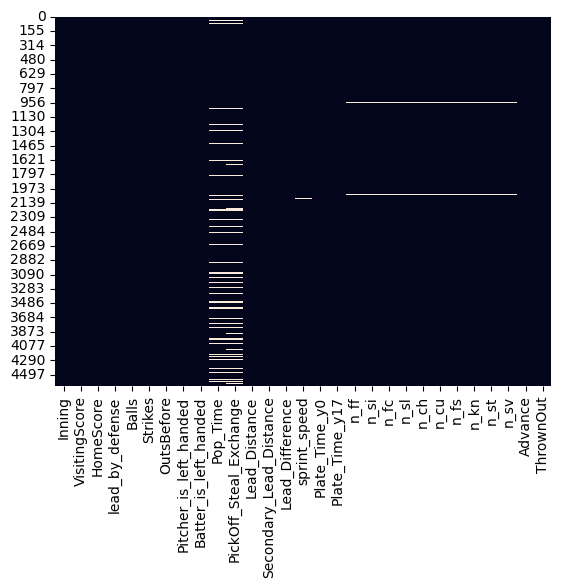

In [39]:
# missing data for initial features selected
missing_val_count_by_column = (steal_2b[features_initial].isna().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

sns.heatmap(steal_2b[features_initial].isnull(), cbar=False)
plt.show()

### Handle Missing values:
- PopTime and Pickoff_Steal_Exchange: impute average values for the given catcher, then fill with overall averages
- sprint_speed: check if sprint_speed is availbale from another year for the runner and use that, otherwise use yearly average
- pitcher aresenal: check if usage is availbale from another year for the pitcher and use that, otherwise use yearly average

#### Catcher - PopTime, PickOff_Steal_Exchange

In [40]:
# get cathers data from statcast
catchers_historical = pd.read_excel('Historical_CS_SB_percent_catcher.xlsx')[['player_id','Year', 'pop_time', 'exchange_time', 'arm_strength']]

# merge to df
steal_2b = steal_2b.merge(catchers_historical, 
               how = 'left', right_on = ['player_id', 'Year'], left_on = ['CatcherIdAll','Year']).drop(
    columns = 'player_id', axis = 1)

# add yearly averages:
catcher_yearly_averages= steal_2b.groupby('Year')[['Pop_Time', 'PickOff_Steal_Exchange', 'arm_strength']].mean()
catcher_yearly_averages.rename(columns = {'Pop_Time' : 'Pop_Time_avg',
                                  'PickOff_Steal_Exchange' :'PickOff_Steal_Exchange_avg' ,
                                  'arm_strength': 'arm_strength_avg'}, inplace = True)

steal_2b = steal_2b.merge(catcher_yearly_averages, on = ['Year'], how = 'left')

# fill in missing values:
steal_2b['Pop_Time'] = steal_2b['Pop_Time'].fillna(steal_2b['pop_time']).fillna(steal_2b['Pop_Time_avg'])
steal_2b['PickOff_Steal_Exchange'] = steal_2b['PickOff_Steal_Exchange'].fillna(steal_2b['exchange_time']).fillna(steal_2b['PickOff_Steal_Exchange_avg'])
steal_2b['arm_strength'] = steal_2b['arm_strength'].fillna(steal_2b['arm_strength_avg'])

#drop columns that are not needed anymore:
#steal_2b.drop(columns = ['pop_time', 'exchange_time', 'Pop_Time_avg','PickOff_Steal_Exchange_avg', 'arm_strength_avg'], axis = 1, inplace = True)

In [41]:
# add arm strength to feature list
features_initial.append('arm_strength')

#### Runner - sprint_speed:

In [42]:
# if sprint_speed is availbale for the player for another year, use that
speed_player_avg = speed.groupby('player_id')[['sprint_speed']].mean().rename(columns = {'sprint_speed': 'sprint_speed_player_avg'})

steal_2b = steal_2b.merge(speed_player_avg, left_on = 'StartRunnerOnFirstId', 
                      right_on = 'player_id', how = 'left') #.drop(columns = 'player_id', axis = 1)


   
# add yearly averages:
speed_yearly_averages = steal_2b.groupby('Year')[['sprint_speed', 'Secondary_Lead_Distance', 'Lead_Distance', 'Lead_Difference']].mean()
speed_yearly_averages.rename(columns = {'sprint_speed' : 'sprint_speed_avg',
                                  'Lead_Distance' :'Lead_Distance_avg' ,
                                  'Secondary_Lead_Distance': 'Secondary_Lead_Distance_avg',
                                 'Lead_Difference': 'Lead_Difference_avg'}, inplace = True)

steal_2b = steal_2b.merge(speed_yearly_averages, on = ['Year'], how = 'left')


# fill in missing values:
steal_2b['sprint_speed'] = steal_2b['sprint_speed'].fillna(steal_2b['sprint_speed_player_avg']).fillna(steal_2b['sprint_speed_avg'])


#drop columns that are not needed anymore:
steal_2b.drop(columns = ['sprint_speed_player_avg', 'sprint_speed_avg', 'Lead_Distance_avg', 'Secondary_Lead_Distance_avg','Lead_Difference_avg'], axis = 1, inplace = True)

#### Pitcher - usage

In [43]:
# if sprint_speed is availbale for the player for another year, use that
arsenal_player_avg = arsenal_usage.groupby('pitcher')[['n_ff', 'n_si', 'n_fc', 'n_sl', 
                                                       'n_ch', 'n_cu', 'n_fs', 'n_kn', 'n_st', 'n_sv']].mean().rename(
                                columns = {'n_ff': 'n_ff_player_avg', 
                                          'n_si': 'n_si_player_avg',
                                          'n_fc': 'n_fc_player_avg', 
                                          'n_sl': 'n_sl_player_avg', 
                                          'n_ch': 'n_ch_player_avg', 
                                          'n_cu': 'n_cu_player_avg', 
                                          'n_fs': 'n_fs_player_avg', 
                                          'n_kn': 'n_kn_player_avg', 
                                          'n_st': 'n_st_player_avg', 
                                          'n_sv' : 'n_sv_player_avg'}) 

steal_2b = steal_2b.merge(arsenal_player_avg, left_on = 'PitcherId', 
                      right_on = 'pitcher', how = 'left') #.drop(columns = 'player_id', axis = 1)


   
# add yearly averages:
pitcher_yearly_averages = steal_2b.groupby('Year')[['n_ff', 'n_si', 'n_fc', 'n_sl', 'n_ch', 'n_cu', 'n_fs', 'n_kn', 'n_st', 'n_sv']].mean()
pitcher_yearly_averages.rename(columns = {'n_ff': 'n_ff_avg', 
                                          'n_si': 'n_si_avg',
                                          'n_fc': 'n_fc_avg', 
                                          'n_sl': 'n_sl_avg', 
                                          'n_ch': 'n_ch_avg', 
                                          'n_cu': 'n_cu_avg', 
                                          'n_fs': 'n_fs_avg', 
                                          'n_kn': 'n_kn_avg', 
                                          'n_st': 'n_st_avg', 
                                          'n_sv' : 'n_sv_avg'}, inplace = True) 
                                         
                                         

steal_2b = steal_2b.merge(pitcher_yearly_averages, on = ['Year'], how = 'left')


# fill in missing values:
steal_2b['n_ff'] = steal_2b['n_ff'].fillna(steal_2b['n_ff_player_avg']).fillna(steal_2b['n_ff_avg'])
steal_2b['n_si'] = steal_2b['n_si'].fillna(steal_2b['n_si_player_avg']).fillna(steal_2b['n_si_avg'])
steal_2b['n_fc'] = steal_2b['n_fc'].fillna(steal_2b['n_fc_player_avg']).fillna(steal_2b['n_fc_avg'])
steal_2b['n_sl'] = steal_2b['n_sl'].fillna(steal_2b['n_sl_player_avg']).fillna(steal_2b['n_sl_avg'])
steal_2b['n_ch'] = steal_2b['n_ch'].fillna(steal_2b['n_ch_player_avg']).fillna(steal_2b['n_ch_avg'])
steal_2b['n_cu'] = steal_2b['n_cu'].fillna(steal_2b['n_cu_player_avg']).fillna(steal_2b['n_cu_avg'])
steal_2b['n_fs'] = steal_2b['n_fs'].fillna(steal_2b['n_fs_player_avg']).fillna(steal_2b['n_fs_avg'])
steal_2b['n_kn'] = steal_2b['n_kn'].fillna(steal_2b['n_kn_player_avg']).fillna(steal_2b['n_kn_avg'])
steal_2b['n_st'] = steal_2b['n_st'].fillna(steal_2b['n_st_player_avg']).fillna(steal_2b['n_st_avg'])
steal_2b['n_sv'] = steal_2b['n_sv'].fillna(steal_2b['n_sv_player_avg']).fillna(steal_2b['n_sv_avg'])


#drop columns that are not needed anymore:
steal_2b.drop(columns = ['n_ff_player_avg', 'n_si_player_avg', 'n_fc_player_avg', 'n_sl_player_avg','n_ch_player_avg',
                        'n_cu_player_avg', 'n_fs_player_avg', 'n_kn_player_avg', 'n_st_player_avg','n_sv_player_avg',
                        'n_ff_avg', 'n_si_avg', 'n_fc_avg', 'n_sl_avg','n_ch_avg',
                        'n_cu_avg', 'n_fs_avg', 'n_kn_avg', 'n_st_avg','n_sv_avg'], axis = 1, inplace = True)

#### Check missing values again:

In [44]:
# check missing values - ok, only id-s
missing_val_count_by_column = (steal_2b[features_initial].isna().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


# Visualizations (continuous features):
I use seaborn plots to visualize continuous features that will help to select relevant features. I create boxplots and violinplots to see if distributions are different for steals and caught steals. Swarmplots show the separation between CS and SB for all features. Before creating the plots I use standardization (differences between values of features are very high to observe on one plot otherwise).

In [45]:
features_initial_cont = [
 'Pop_Time',
 'PickOff_Steal_Exchange',
 'arm_strength',
 'Lead_Distance',
 'Secondary_Lead_Distance',
 'Lead_Difference',
 'sprint_speed',
 'Plate_Time_y0',
 'Plate_Time_y17',
 'n_ff',
 'n_si',
 'n_fc',
 'n_sl',
 'n_ch',
 'n_cu',
 'n_fs',
 'n_kn',
 'n_st',
 'n_sv'
]

# rest- categorical:
features_initial_categ =  list(steal_2b[features_initial].drop(steal_2b[features_initial_cont], axis = 1).columns)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'Pop_Time'),
  Text(1, 0, 'PickOff_Steal_Exchange'),
  Text(2, 0, 'arm_strength'),
  Text(3, 0, 'Lead_Distance'),
  Text(4, 0, 'Secondary_Lead_Distance'),
  Text(5, 0, 'Lead_Difference'),
  Text(6, 0, 'sprint_speed'),
  Text(7, 0, 'Plate_Time_y0'),
  Text(8, 0, 'Plate_Time_y17'),
  Text(9, 0, 'n_ff'),
  Text(10, 0, 'n_si'),
  Text(11, 0, 'n_fc'),
  Text(12, 0, 'n_sl'),
  Text(13, 0, 'n_ch'),
  Text(14, 0, 'n_cu'),
  Text(15, 0, 'n_fs'),
  Text(16, 0, 'n_kn'),
  Text(17, 0, 'n_st'),
  Text(18, 0, 'n_sv')])

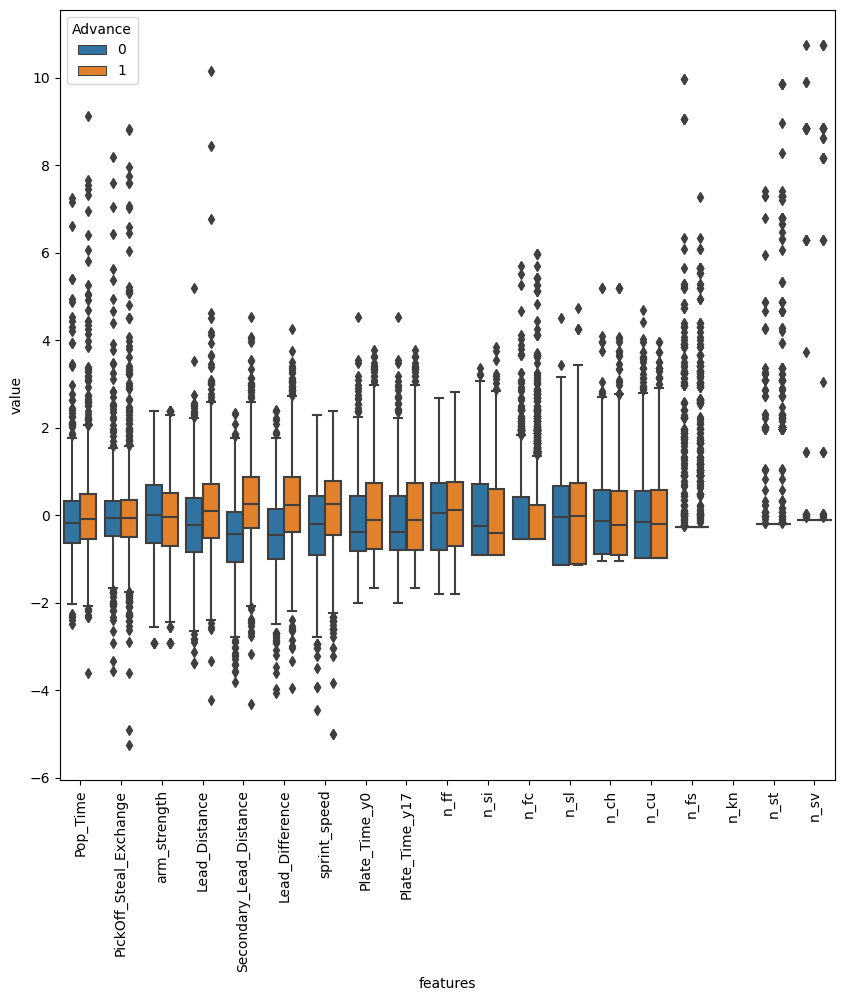

In [46]:
#boxplot 
data = steal_2b[features_initial_cont]
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([steal_2b['Advance'] , data_n_2],axis=1)
data = pd.melt(data,id_vars="Advance",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="Advance", data=data)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'Pop_Time'),
  Text(1, 0, 'PickOff_Steal_Exchange'),
  Text(2, 0, 'arm_strength'),
  Text(3, 0, 'Lead_Distance'),
  Text(4, 0, 'Secondary_Lead_Distance'),
  Text(5, 0, 'Lead_Difference'),
  Text(6, 0, 'sprint_speed'),
  Text(7, 0, 'Plate_Time_y0'),
  Text(8, 0, 'Plate_Time_y17'),
  Text(9, 0, 'n_ff'),
  Text(10, 0, 'n_si'),
  Text(11, 0, 'n_fc'),
  Text(12, 0, 'n_sl'),
  Text(13, 0, 'n_ch'),
  Text(14, 0, 'n_cu'),
  Text(15, 0, 'n_fs'),
  Text(16, 0, 'n_kn'),
  Text(17, 0, 'n_st'),
  Text(18, 0, 'n_sv')])

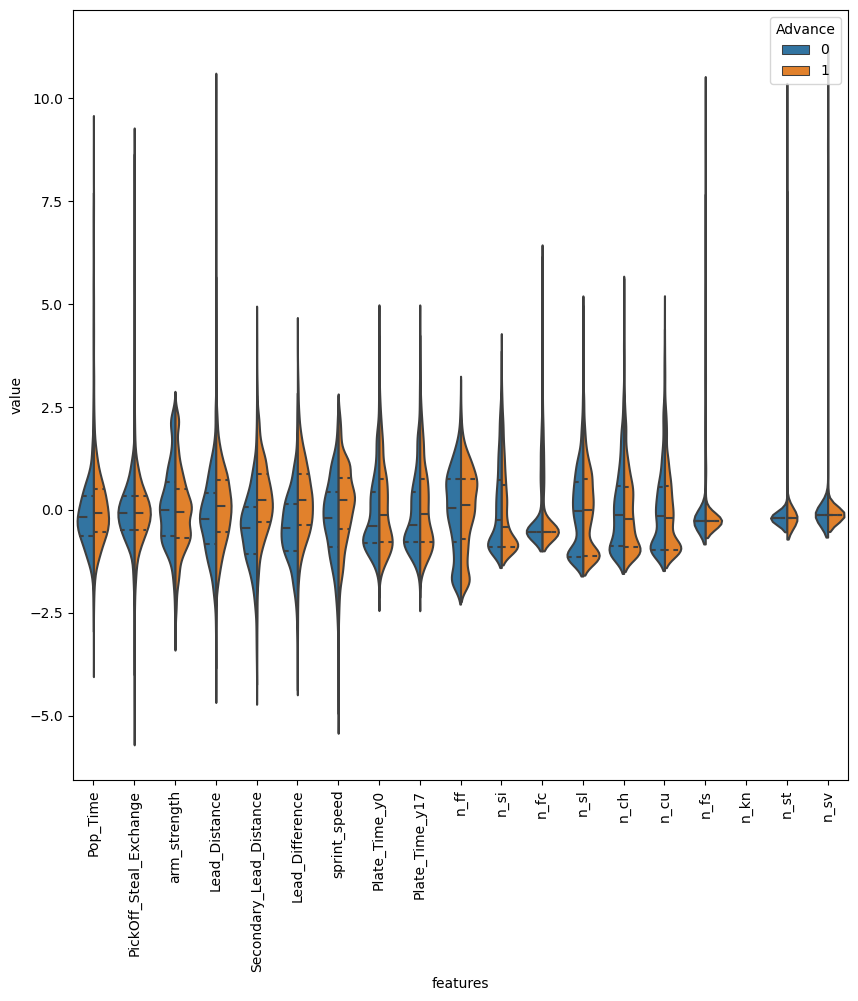

In [47]:
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="Advance", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

Some pitch types has very few values, won't be useful for classification, I remove them from feature list:

In [48]:
for feature in ['n_fs', 'n_kn', 'n_st', 'n_sv']:
    features_initial.remove(feature)
    
for feature in ['n_fs', 'n_kn', 'n_st', 'n_sv']:
    features_initial_cont.remove(feature)

Boxplots are good to see outliers and see if a feature can be good for classification (median of CS and SB are separated). For example, Lead_Distance and Secondary_Lead_Distance and sprint_speed might be good since median of the CS and SB are far from each other, however Pickoff_Steal_Exchange does not look like separated which means it doesn't have good information for classification.

Secondary_Lead_Distance and Lead_Difference looks very similar. I will check correlation between them and also between Poptime and Pickoff_Steal_Exhcnage. If they are correlated we can drop one of them.

Plate_time_y0 and Plate_time_y17 are also very similar , I would keep only one of them.

Pitch usage percentages for different pitch types do not look like good separator, those might get removed later as well.

                        Pop_Time  PickOff_Steal_Exchange
Pop_Time                1.000000                0.721349
PickOff_Steal_Exchange  0.721349                1.000000


C:\Users\eniko\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


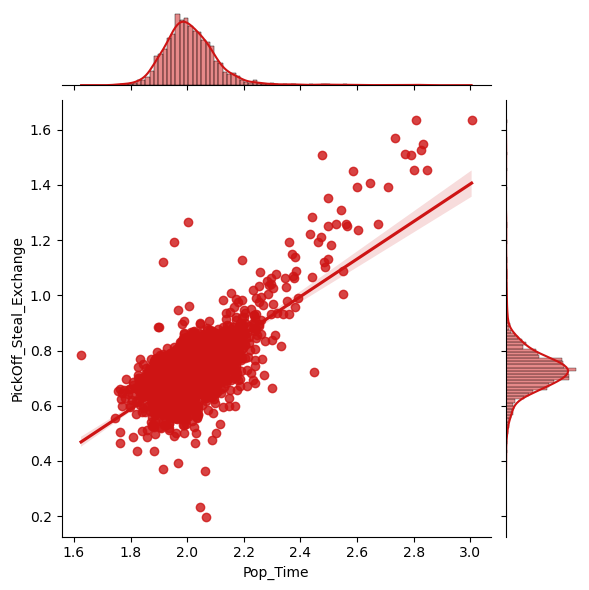

In [49]:
# Pop_Time and PickOff_Steal_Exchange
print(steal_2b[['Pop_Time', 'PickOff_Steal_Exchange']].corr())
sns.jointplot(steal_2b.loc[:, 'Pop_Time'], steal_2b.loc[:, 'PickOff_Steal_Exchange'], kind="reg", color="#ce1414")

                         Lead_Distance  Secondary_Lead_Distance  \
Lead_Distance                 1.000000                 0.388305   
Secondary_Lead_Distance       0.388305                 1.000000   
Lead_Difference               0.003316                 0.922814   

                         Lead_Difference  
Lead_Distance                   0.003316  
Secondary_Lead_Distance         0.922814  
Lead_Difference                 1.000000  


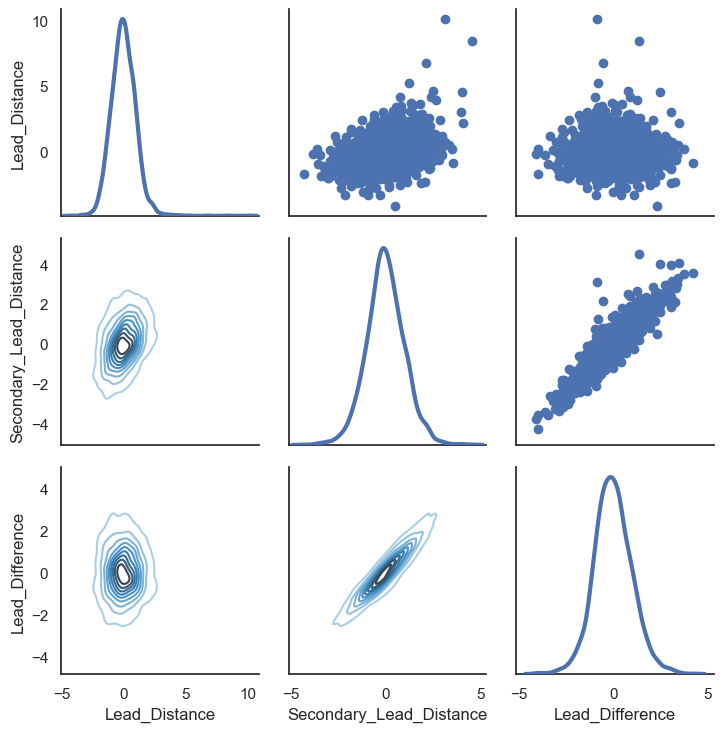

In [50]:
print(steal_2b[['Lead_Distance', 'Secondary_Lead_Distance', 'Lead_Difference']].corr())
sns.set(style = "white")
df = data_n_2[['Lead_Distance', 'Secondary_Lead_Distance', 'Lead_Difference']].dropna(how = "any")
g = sns.PairGrid(df, diag_sharey= False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

                         Secondary_Lead_Distance  Lead_Difference
Secondary_Lead_Distance                 1.000000         0.922814
Lead_Difference                         0.922814         1.000000


C:\Users\eniko\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


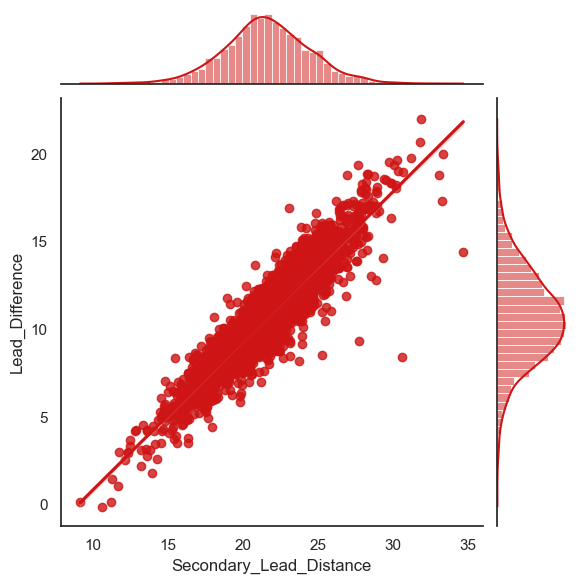

In [51]:
# Secondary_Lead_Distance and Lead_Difference
print(steal_2b[['Secondary_Lead_Distance', 'Lead_Difference']].corr())
sns.jointplot(steal_2b.loc[:, 'Secondary_Lead_Distance'], steal_2b.loc[:, 'Lead_Difference'], kind="reg", color="#ce1414")

C:\Users\eniko\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 31.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\eniko\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 37.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\eniko\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 30.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\eniko\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 27.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\eniko\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 26.2% of the points

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Pop_Time'),
  Text(1, 0, 'PickOff_Steal_Exchange'),
  Text(2, 0, 'arm_strength'),
  Text(3, 0, 'Lead_Distance'),
  Text(4, 0, 'Secondary_Lead_Distance'),
  Text(5, 0, 'Lead_Difference'),
  Text(6, 0, 'sprint_speed'),
  Text(7, 0, 'Plate_Time_y0'),
  Text(8, 0, 'Plate_Time_y17')])

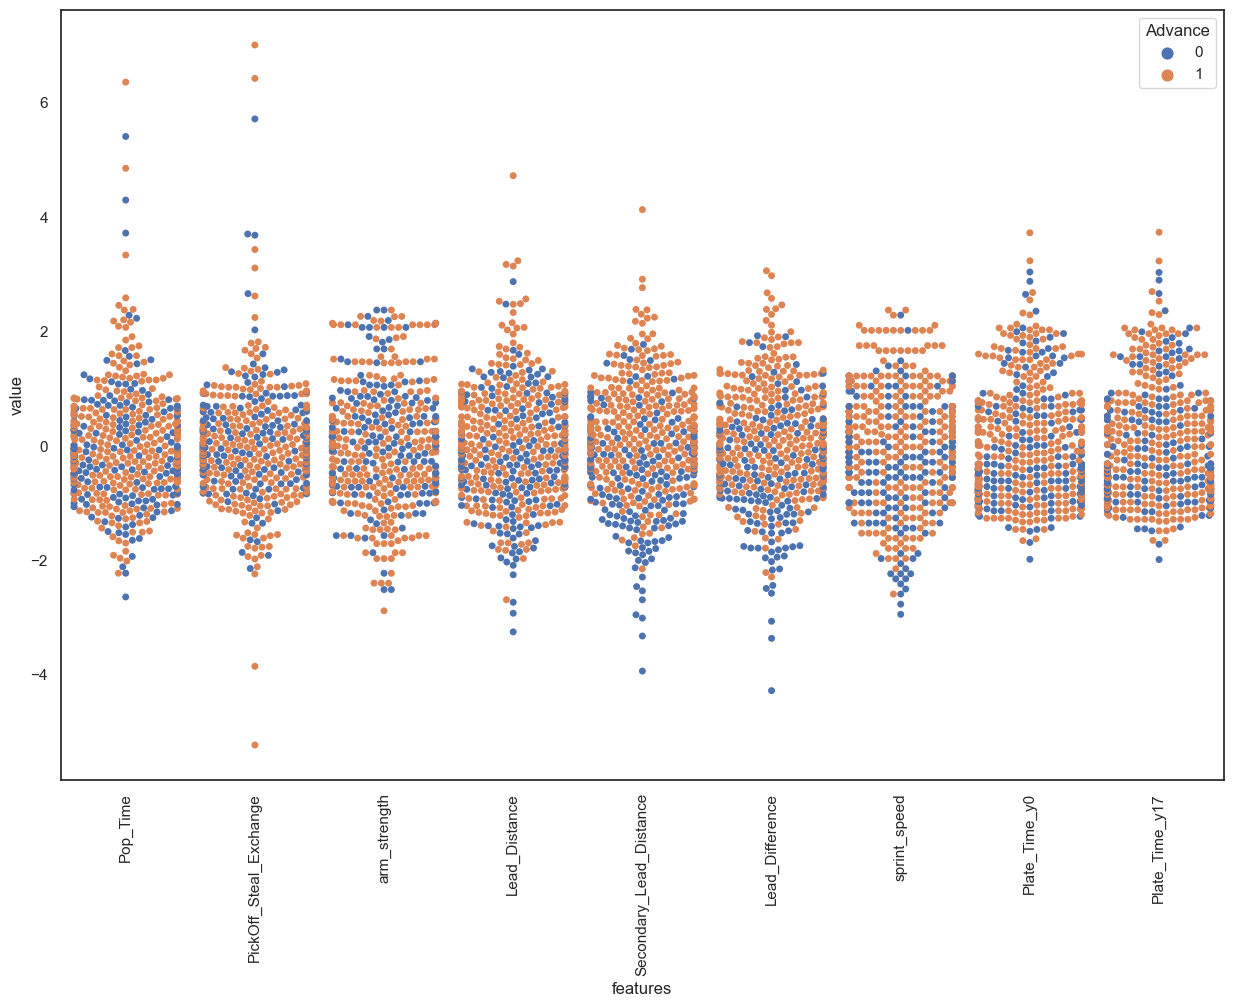

In [52]:
# create swarmplot with a random sample (due to too many data points):
data_sample = steal_2b.sample(n=500)

data = data_sample[['Pop_Time', 'PickOff_Steal_Exchange', 'arm_strength', 'Lead_Distance', 'Secondary_Lead_Distance',
                  'Lead_Difference', 'sprint_speed', 'Plate_Time_y0', 'Plate_Time_y17']]
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([data_sample['Advance'] , data_n_2],axis=1)
data = pd.melt(data,id_vars="Advance",
                    var_name="features",
                    value_name='value')

#swarmplot
plt.figure(figsize=(15, 10))
sns.swarmplot(x="features", y = "value", hue = "Advance", data =data)

plt.xticks(rotation=90)

Looking at the above swarmplots Secondary_Lead_Distance shows the best separation between SB and CS.
We might need new features for better classification.

Finally I check the correlations for the above features.

<AxesSubplot:>

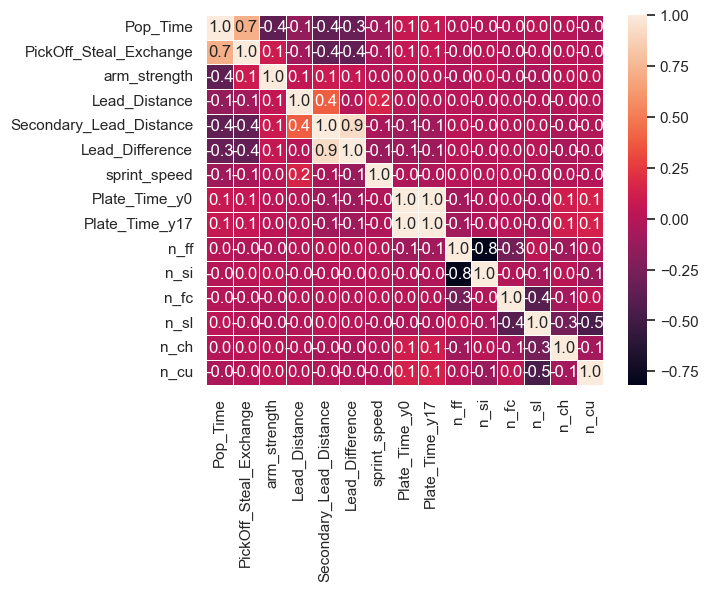

In [53]:
plt.figure(1)
corr = steal_2b[features_initial_cont].corr()
sns.heatmap(corr, annot= True, linewidth = .5, fmt = '.1f')

- As 'Secondary_Lead_Distance' and 'Lead_Difference' are correlated to each other I will keep the original 'Secondary_Lead_Distance' only. 

- Plate_Time_y17 and Plate_Time_y0 are highly correlated. I will keep Plate_Time_y17 only.

- 'n_ff', 'n_si' are both correlated, I will only keep 'n_si'.
- PickOff_Steal_Exchange and PopTime are correlated but both can be kept. PopTime seems to be a better separator between CS and SB, PickOff_Steal_exchange might get dropped later.

In [54]:
# remove correlated features from features_list
for feature in ['Lead_Difference', 'Plate_Time_y0' , 'n_ff']: 
    features_initial.remove(feature)

# Categorical features:
I will make some transformation on categorical features and create some new features.

In [55]:
features_initial_categ

['Inning',
 'VisitingScore',
 'HomeScore',
 'lead_by_defense',
 'Balls',
 'Strikes',
 'OutsBefore',
 'Pitcher_is_left_handed',
 'Batter_is_left_handed',
 'Advance',
 'ThrownOut']

### Balls, Strikes, OutsBefore:

Here I will use mean encoding which uses the target variable to generate the new encoded feature: for each unique value in the categorical feature we add the ratio of occurrence of the positive class in the target variable which is the SB rate. Steps are: select categorical variable, group by the categorical variable and calculate aggregated sum and count of target variable, divide sum by count (which is basically its mean) and join it back to dataset.

C:\Users\eniko\AppData\Local\Temp\ipykernel_7764\1222796500.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_encode = steal_2b.groupby('Balls')['Advance', 'ThrownOut'].agg({'Advance': ['mean', 'sum'], 'ThrownOut': ['sum', 'count']})
C:\Users\eniko\AppData\Local\Temp\ipykernel_7764\1222796500.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_encode = steal_2b.groupby('Strikes')['Advance', 'ThrownOut'].agg({'Advance': ['mean', 'sum'], 'ThrownOut': ['sum', 'count']})
C:\Users\eniko\AppData\Local\Temp\ipykernel_7764\1222796500.py:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_encode = steal_2b.groupby('OutsBefore')['Advance', 'ThrownOut'].agg({'Advance': ['mean', 'sum'], 'ThrownOut': ['sum', 'count']})


        Advance      ThrownOut      
           mean  sum       sum count
Balls                               
0      0.668213  864       429  1293
1      0.628918  622       367   989
2      0.643653  289       160   449
3      0.354430  112       204   316
          Advance      ThrownOut      
             mean  sum       sum count
Strikes                               
0        0.665279  799       402  1201
1        0.642857  576       320   896
2        0.538947  512       438   950
             Advance      ThrownOut      
                mean  sum       sum count
OutsBefore                               
0           0.607050  465       301   766
1           0.565292  658       506  1164
2           0.683975  764       353  1117


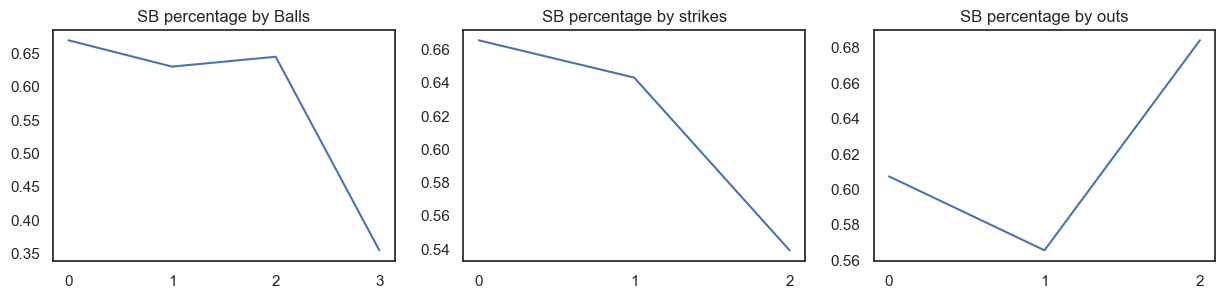

In [56]:
fig, ax = plt.subplots(1,3, figsize = (15,3) )
#balls
mean_encode = steal_2b.groupby('Balls')['Advance', 'ThrownOut'].agg({'Advance': ['mean', 'sum'], 'ThrownOut': ['sum', 'count']})
print(pd.DataFrame(mean_encode))
mean_encode = pd.DataFrame(mean_encode)['Advance']['mean']
steal_2b['Balls_mean_enc'] = steal_2b['Balls'].map(mean_encode)

ax[0].plot(mean_encode)
ax[0].set_xticks(list(mean_encode.index))
ax[0].title.set_text("SB percentage by Balls")

#strikes
mean_encode = steal_2b.groupby('Strikes')['Advance', 'ThrownOut'].agg({'Advance': ['mean', 'sum'], 'ThrownOut': ['sum', 'count']})
print(pd.DataFrame(mean_encode))
mean_encode = pd.DataFrame(mean_encode)['Advance']['mean']
steal_2b['Strikes_mean_enc'] = steal_2b['Strikes'].map(mean_encode)

ax[1].plot(mean_encode)
ax[1].set_xticks(  list(mean_encode.index))
ax[1].title.set_text("SB percentage by strikes")

#outs
mean_encode = steal_2b.groupby('OutsBefore')['Advance', 'ThrownOut'].agg({'Advance': ['mean', 'sum'], 'ThrownOut': ['sum', 'count']})
print(pd.DataFrame(mean_encode))
mean_encode = pd.DataFrame(mean_encode)['Advance']['mean']
steal_2b['OutsBefore_mean_enc'] = steal_2b['OutsBefore'].map(mean_encode)

ax[2].plot(mean_encode)
ax[2].set_xticks(list(mean_encode.index))
ax[2].title.set_text("SB percentage by outs")

#### Inning
There are some steal attempts in innings later than the 9th that I will regroup and put all 9+ innings into 9th to handle small data issue (some innings have 0 or 100% SB rates otherwise). Then I use the same mean encoding technique as earlier.

C:\Users\eniko\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Inning', ylabel='count'>

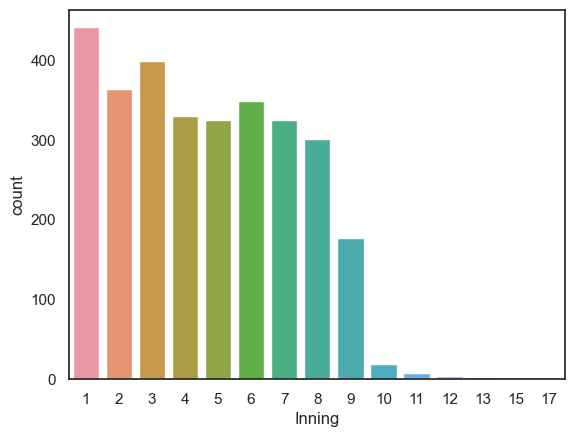

In [57]:
sns.countplot(steal_2b["Inning"], label="Count")

Text(0.5, 1.0, 'SB percentage by inning state')

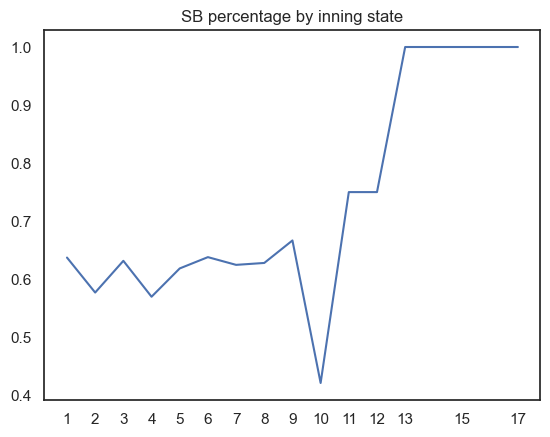

In [58]:
mean_encode = steal_2b.groupby('Inning')['Advance'].mean()
plt.plot(mean_encode)
plt.xticks(list(mean_encode.index))
plt.title("SB percentage by inning state")


                Advance      ThrownOut      
                   mean  sum       sum count
Inning_capped                               
1              0.637188  281       160   441
2              0.576923  210       154   364
3              0.631579  252       147   399
4              0.569697  188       142   330
5              0.618462  201       124   325
6              0.637931  222       126   348
7              0.624615  203       122   325
8              0.627907  189       112   301
9              0.658879  141        73   214


C:\Users\eniko\AppData\Local\Temp\ipykernel_7764\1373641934.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_encode = steal_2b.groupby('Inning_capped')['Advance', 'ThrownOut'].agg({'Advance': ['mean', 'sum'], 'ThrownOut': ['sum', 'count']})


Text(0.5, 1.0, 'SB percentage by inning state')

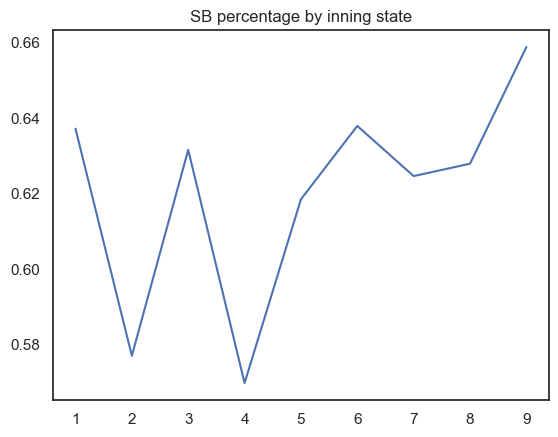

In [59]:
steal_2b['Inning_capped'] = np.where(steal_2b.Inning >= 9, 9, steal_2b.Inning)
mean_encode = steal_2b.groupby('Inning_capped')['Advance', 'ThrownOut'].agg({'Advance': ['mean', 'sum'], 'ThrownOut': ['sum', 'count']})
print(mean_encode)
mean_encode = pd.DataFrame(mean_encode)['Advance']['mean']
steal_2b.loc[:, 'Inning_mean_enc'] = steal_2b['Inning_capped'].map(mean_encode)

plt.plot(mean_encode)
plt.xticks(list(mean_encode.index))
plt.title("SB percentage by inning state")


#### Score / lead_by_defense
Same as for innings: I group the 5 and 5+ leads together and use mean encoding.

C:\Users\eniko\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lead_by_defense', ylabel='count'>

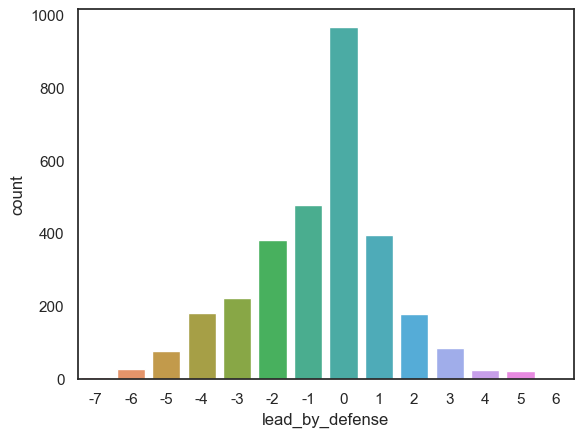

In [60]:
sns.countplot(steal_2b["lead_by_defense"], label="Count")

Text(0.5, 1.0, 'SB percentage by inning state')

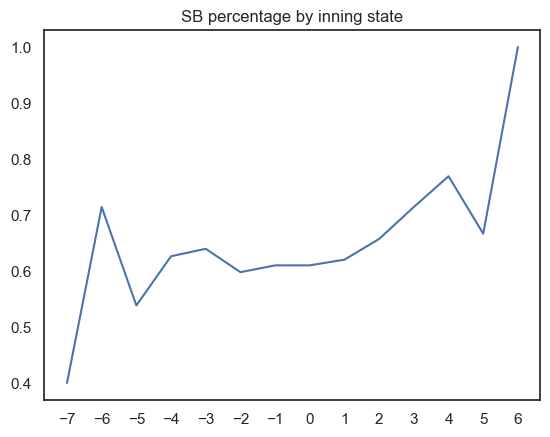

In [61]:
mean_encode = steal_2b.groupby('lead_by_defense')['Advance'].mean()
plt.plot(mean_encode)
plt.xticks(list(mean_encode.index))
plt.title("SB percentage by inning state")

                         Advance      ThrownOut      
                            mean  sum       sum count
lead_by_defense_capped                               
-5                      0.576577   64        47   111
-4                      0.626374  114        68   182
-3                      0.639640  142        80   222
-2                      0.597911  229       154   383
-1                      0.610063  291       186   477
 0                      0.610134  590       377   967
 1                      0.620253  245       150   395
 2                      0.657303  117        61   178
 3                      0.714286   60        24    84
 4                      0.769231   20         6    26
 5                      0.681818   15         7    22


C:\Users\eniko\AppData\Local\Temp\ipykernel_7764\1905964538.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_encode = steal_2b.groupby('lead_by_defense_capped')['Advance', 'ThrownOut'].agg({'Advance': ['mean', 'sum'], 'ThrownOut': ['sum', 'count']})


Text(0.5, 1.0, 'SB success percentage by lead by defense state')

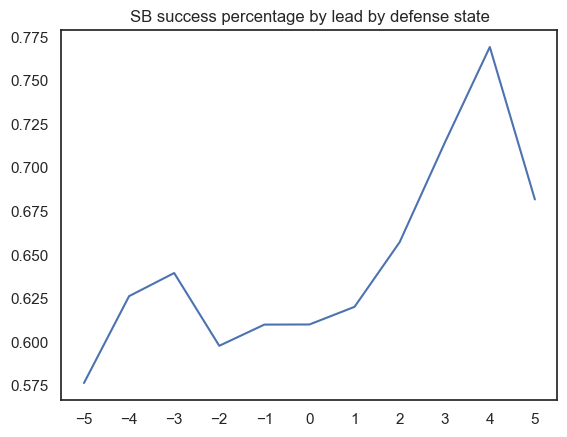

In [62]:
steal_2b['lead_by_defense_capped'] = np.where(steal_2b.lead_by_defense >= 5, 5, 
                                         np.where(steal_2b.lead_by_defense <= -5, -5, steal_2b.lead_by_defense))
mean_encode = steal_2b.groupby('lead_by_defense_capped')['Advance', 'ThrownOut'].agg({'Advance': ['mean', 'sum'], 'ThrownOut': ['sum', 'count']})
print(mean_encode)
mean_encode = pd.DataFrame(mean_encode)['Advance']['mean']
steal_2b.loc[:, 'lead_by_defense_mean_enc'] = steal_2b['lead_by_defense_capped'].map(mean_encode)

plt.plot(mean_encode)
plt.xticks(list(mean_encode.index))
plt.title("SB success percentage by lead by defense state")


In [63]:
#update features list
features_categorical_new =  ['OutsBefore_mean_enc', 'Balls_mean_enc', 'Strikes_mean_enc', 'Inning_mean_enc','lead_by_defense_mean_enc'] 
features_initial = features_initial + features_categorical_new

for feature in ['OutsBefore', 'Balls', 'Strikes', 'Inning', 'lead_by_defense']: 
    features_initial.remove(feature)

#### Game states - when they steal
I created some tables to see when the steals are most successful and when steal attempts happen. These tables are based on the original dataset before removing missing values, outlier, etc, to represent true SB success rates.

In [64]:
#score 
score = df_runner_on_1st.groupby(['Balls', 'Strikes'])['Advance', 'ThrownOut'].sum()
score['total'] = score['Advance'] + score['ThrownOut']
score['SB_success'] = score['Advance'] / score['total']
score['CS_percent'] = score['ThrownOut'] / score['total']

print('Average SB success rate: ', score['SB_success'].mean())
score.sort_values(by = 'SB_success', ascending = False)

Average SB success rate:  0.7529573778124727


C:\Users\eniko\AppData\Local\Temp\ipykernel_7764\2767455518.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  score = df_runner_on_1st.groupby(['Balls', 'Strikes'])['Advance', 'ThrownOut'].sum()


Advance  ThrownOut  total  SB_success  CS_percent
Balls Strikes                                                   
3     0             13          2     15    0.866667    0.133333
2     0            110         26    136    0.808824    0.191176
      2            283         71    354    0.799435    0.200565
1     2            405        112    517    0.783366    0.216634
0     1            489        136    625    0.782400    0.217600
      0            836        238   1074    0.778399    0.221601
      2            267         80    347    0.769452    0.230548
3     1             26          8     34    0.764706    0.235294
1     1            370        123    493    0.750507    0.249493
      0            441        153    594    0.742424    0.257576
2     1            190         71    261    0.727969    0.272031
3     2            179        209    388    0.461340    0.538660

Success rate on 3-2 count is very low but there are still many attempts. On 3-2 if the pitch is a ball, the hitter will walk and runner advances to second, if it is a strike hitter is out and the steal attempt can happen (with less than 2 outs). Using the run values we can calculate a break-even point where the steal attempt has 0 influence - zero expected change in the run expectancy. If the model predicts higher probability, steal attempt can happen. These break-even points can be different in different game situations, and in a 3-2 count the breakeven point is lower since the alternatives includes an out.

Since most steals happen on 0-0 count first strike percentage might be a good feature to add.

In [66]:
#outs - balls- strikes states by total number of attempts
score_with_outs = df_runner_on_1st.groupby([ 'OutsBefore', 'Balls', 'Strikes'])['Advance', 'ThrownOut'].sum()
score_with_outs['total'] = score_with_outs['Advance'] + score_with_outs['ThrownOut']
score_with_outs['SB_success'] = score_with_outs['Advance'] / score_with_outs['total']
score_with_outs['CS_percent'] = score_with_outs['ThrownOut'] / score_with_outs['total']


score_with_outs.sort_values(by = 'total', ascending = False)

C:\Users\eniko\AppData\Local\Temp\ipykernel_7764\530001824.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  score_with_outs = df_runner_on_1st.groupby([ 'OutsBefore', 'Balls', 'Strikes'])['Advance', 'ThrownOut'].sum()


Advance  ThrownOut  total  SB_success  CS_percent
OutsBefore Balls Strikes                                                   
2          0     0            361         82    443    0.814898    0.185102
1          0     0            297        104    401    0.740648    0.259352
2          0     1            217         58    275    0.789091    0.210909
           1     2            194         52    246    0.788618    0.211382
0          0     0            178         52    230    0.773913    0.226087
1          3     2            103        123    226    0.455752    0.544248
2          1     0            181         42    223    0.811659    0.188341
1          0     1            171         48    219    0.780822    0.219178
           1     0            140         65    205    0.682927    0.317073
2          1     1            156         40    196    0.795918    0.204082
1          1     1            130         48    178    0.730337    0.269663
2          0     2            139         34    173    0.803468    0.196532
0          1     0            120         46    166    0.722892    0.277108
           3     2             75         85    160    0.468750    0.531250
1          1     2            115         37    152    0.756579    0.243421
2          2     2            105         35    140    0.750000    0.250000
1          2     2            107         26    133    0.804511    0.195489
0          0     1            101         30    131    0.770992    0.229008
           1     2             96         23    119    0.806723    0.193277
                 1             84         35    119    0.705882    0.294118
1          2     1             76         32    108    0.703704    0.296296
           0     2             70         34    104    0.673077    0.326923
2          2     1             63         25     88    0.715909    0.284091
0          2     2             71         10     81    0.876543    0.123457
           0     2             58         12     70    0.828571    0.171429
           2     1             51         14     65    0.784615    0.215385
2          2     0             50         10     60    0.833333    0.166667
1          2     0             39         10     49    0.795918    0.204082
0          2     0             21          6     27    0.777778    0.222222
1          3     1             11          3     14    0.785714    0.214286
2          3     1              9          2     11    0.818182    0.181818
0          3     1              6          3      9    0.666667    0.333333
                 0              5          1      6    0.833333    0.166667
2          3     0              6          0      6    1.000000    0.000000
1          3     0              2          1      3    0.666667    0.333333
2          3     2              1          1      2    0.500000    0.500000

Most steals happen on 0-0 count with 2 or 1 outs. With 2 outs, success rate is 81%. Here the defense is less concered about the runner and the focus is more on the hitter. 

Interestingly, 1 out on 3-2 count is also very popular. There are many steal attemps (226) although the success rate is very low (46%) compared to the average 75%.

In [67]:
#inning - outs - balls- strikes states by total number of attempts
score_with_outs_and_inning = df_runner_on_1st.groupby([ 'Inning','OutsBefore', 'Balls', 'Strikes'])['Advance', 'ThrownOut'].sum()
score_with_outs_and_inning['total'] = score_with_outs_and_inning['Advance'] + score_with_outs_and_inning['ThrownOut']
score_with_outs_and_inning['SB_success'] = score_with_outs_and_inning['Advance'] / score_with_outs_and_inning['total']
score_with_outs_and_inning['CS_percent'] = score_with_outs_and_inning['ThrownOut'] / score_with_outs_and_inning['total']


score_with_outs_and_inning.sort_values(by = 'total', ascending = False)[0:20]

C:\Users\eniko\AppData\Local\Temp\ipykernel_7764\2383843896.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  score_with_outs_and_inning = df_runner_on_1st.groupby([ 'Inning','OutsBefore', 'Balls', 'Strikes'])['Advance', 'ThrownOut'].sum()


Advance  ThrownOut  total  SB_success  \
Inning OutsBefore Balls Strikes                                          
6      2          0     0             46         12     58    0.793103   
7      1          0     0             44         14     58    0.758621   
3      2          0     0             47         10     57    0.824561   
7      2          0     0             45         11     56    0.803571   
5      2          0     0             45          9     54    0.833333   
6      1          0     0             40         13     53    0.754717   
1      1          0     0             43          8     51    0.843137   
3      1          0     0             39         11     50    0.780000   
8      2          0     0             43          6     49    0.877551   
1      2          0     0             37          8     45    0.822222   
2      2          0     0             36          7     43    0.837209   
8      1          0     0             32         11     43    0.744186   
4      2          0     0             30         12     42    0.714286   
       1          0     0             31         11     42    0.738095   
5      1          0     0             27         11     38    0.710526   
2      2          0     1             33          4     37    0.891892   
1      0          0     0             34          3     37    0.918919   
3      2          0     1             23         13     36    0.638889   
2      1          0     0             22         14     36    0.611111   
6      2          0     1             31          5     36    0.861111   

                                 CS_percent  
Inning OutsBefore Balls Strikes              
6      2          0     0          0.206897  
7      1          0     0          0.241379  
3      2          0     0          0.175439  
7      2          0     0          0.196429  
5      2          0     0          0.166667  
6      1          0     0          0.245283  
1      1          0     0          0.156863  
3      1          0     0          0.220000  
8      2          0     0          0.122449  
1      2          0     0          0.177778  
2      2          0     0          0.162791  
8      1          0     0          0.255814  
4      2          0     0          0.285714  
       1          0     0          0.261905  
5      1          0     0          0.289474  
2      2          0     1          0.108108  
1      0          0     0          0.081081  
3      2          0     1          0.361111  
2      1          0     0          0.388889  
6      2          0     1          0.138889

Adding the innings to the table, the 0-0 counts are still on top with 1 or 2 outs. Most of the times it is in 5-6-7th and 3rd innings with higher success rate in earlier innings. 

### 3-2 Count:
On 3-2 count the stolen base success rate is 46% compared to 75% on average and still there are many attempts (388), since the break-even point is much lower. The alternative here is not the same game state in every situation state but one more out.
- 1 out 226 attempts  (46% success)
- 0 outs 160 attempt (47% success)
- 2 outs 2 attempts (50% success)

With 3-2 count, the runner tries to avoid a double play if the batter hits a ground ball and is in motion earlier, so he can get to scoring position instead of being an out. It might also help the batter with distracting the catcher and there is more chance for a ball and a walk.

Due to the above I would expect higher lead on 3-2 counts then other counts, although I see the opposite:

<AxesSubplot:xlabel='Secondary_Lead_Distance', ylabel='Density'>

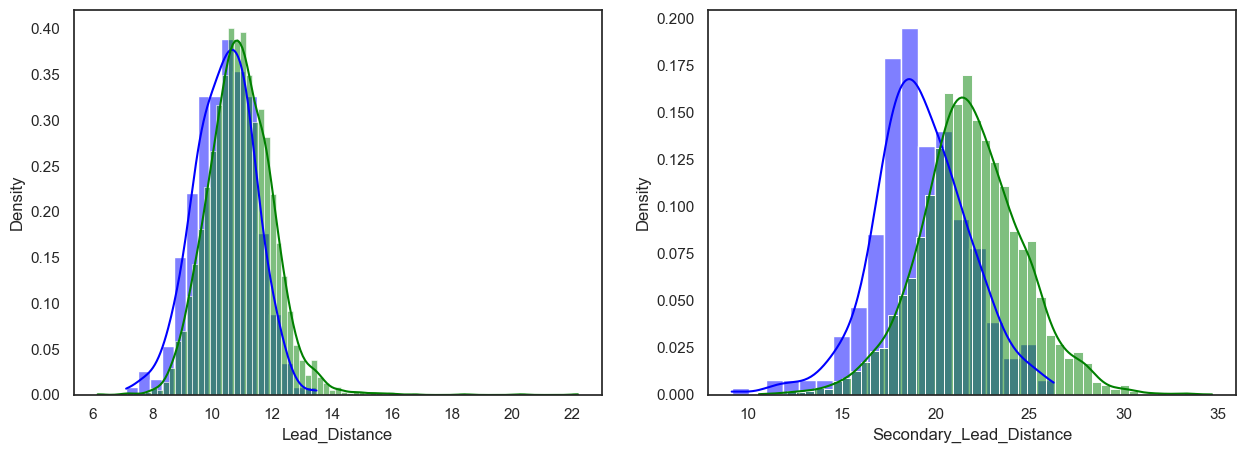

In [71]:
steal_2b['3-2Count'] = np.where((steal_2b['Balls'] == 3) & (steal_2b['Strikes'] == 2), 1, 0)

fig, axs = plt.subplots(1, 2, figsize = (15,5))

sns.histplot(data=steal_2b[(steal_2b['3-2Count']== 1) ] , 
             x='Lead_Distance', color = 'blue', kde = True, stat = 'density', ax =axs[0])
sns.histplot(data=steal_2b[(steal_2b['3-2Count']== 0) ],  
             x='Lead_Distance', color = 'green', kde = True, stat = 'density', ax =axs[0])

sns.histplot(data=steal_2b[(steal_2b['3-2Count']== 1) ] , 
             x='Secondary_Lead_Distance', color = 'blue', kde = True, stat = 'density', ax =axs[1])
sns.histplot(data=steal_2b[(steal_2b['3-2Count']== 0) ], 
             x='Secondary_Lead_Distance', color = 'green', kde = True, stat = 'density', ax =axs[1])

In [72]:
steal_2b.groupby( ['3-2Count', 'Advance'])[['Lead_Distance', 'Secondary_Lead_Distance']].mean()

Lead_Distance  Secondary_Lead_Distance
3-2Count Advance                                        
0        0            10.732158                20.492391
         1            11.052060                22.587615
1        0            10.343644                18.703918
         1            10.510835                20.306187

In [73]:
steal_2b.groupby( ['3-2Count'])[['Lead_Distance', 'Secondary_Lead_Distance']].mean()

Lead_Distance  Secondary_Lead_Distance
3-2Count                                        
0             10.940176                21.854818
1             10.397028                19.215519

Interestingly what I see it that the Lead Distance is a little smaller on 3-2 count but the Secondary_Lead_Distance is more smaller on 3-2 count (blue lines) than on other counts.

# Adding new features - Historical SB success rates
I will add historical stolen base success rates against the pitchers, catchers and for runners. 
To handle the issue of small sample sizes I will use regression to the mean technique (a player’s true ability is some mixture of his observed performance and the average performance of some smartly selected population to which that player belongs). I will simply use the average of all players in the calculation although there must be a more sophisticated way to regress them to their true talent using similar players' data (for example players with similar amount of steal attempts). 
The players with more data will be closer to observed performance while players with a few data will end up with values pretty close to the population's success rate.

In [74]:
steal_2b.groupby('Year')[['Advance', 'ThrownOut']].sum()

Advance  ThrownOut
Year                    
2019      906        529
2020      323        187
2021      658        444

In [75]:
# calculate historical SB success rates for
# pitchers
pitchers_historical = pd.read_excel('Historical_CS_SB_percent_pitcher.xlsx')
pitchers_historical['SB_attempt'] = pitchers_historical['p_stolen_base_2b'] + pitchers_historical['p_caught_stealing_2b']
pitchers_historical['Pitcher_Name'] = pitchers_historical[' first_name'] + ' ' + pitchers_historical['last_name']

# runners
df_runner_on_1st['Year'] = df_runner_on_1st['GameTime'].apply(lambda x: x[0: 4]).astype(str).astype(int)
runners_historical = df_runner_on_1st.groupby(['StartRunnerOnFirstId', 'Year'], as_index=False)[['Advance', 'ThrownOut']].sum() 
runners_historical['SB_attempt'] = runners_historical['Advance'] + runners_historical['ThrownOut']
runners_historical['SB_percent'] = runners_historical['Advance'] / (runners_historical['Advance'] + runners_historical['ThrownOut'])
runners_historical['CS_percent'] = runners_historical['ThrownOut'] / (runners_historical['Advance'] + runners_historical['ThrownOut'])

# catchers
catchers_historical = pd.read_excel('Historical_CS_SB_percent_catcher.xlsx')
catchers_historical['n_sb'] = catchers_historical['sb_attempts'] - catchers_historical['n_cs']
catchers_historical['SB_percent'] = ( catchers_historical['sb_attempts'] - catchers_historical['n_cs']) / catchers_historical['sb_attempts']


C:\Users\eniko\AppData\Local\Temp\ipykernel_7764\3910831644.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runner_on_1st['Year'] = df_runner_on_1st['GameTime'].apply(lambda x: x[0: 4]).astype(str).astype(int)


In [76]:
# Regression to the mean
# =====================================
#calculate the mean success percentage and add x mean values to the individual percentages
# runners:
mean_runner = df_runner_on_1st.groupby(['Year'], as_index=False)[['Advance', 'ThrownOut']].sum()
mean_runner['SB_attempt'] = mean_runner['Advance'] + mean_runner['ThrownOut']
mean_runner['SB_percent'] = mean_runner['Advance'] / (mean_runner['Advance'] + mean_runner['ThrownOut'])
mean_runner['CS_percent'] = mean_runner['ThrownOut'] / (mean_runner['Advance'] + mean_runner['ThrownOut'])
mean_runner.head()

runners_historical = runners_historical.merge(mean_runner[['Year', 'SB_percent']], 
                                              left_on = ['Year'], right_on = ['Year'], 
                                              how = 'left', suffixes = {'', '_mean'})

# pitchers:
mean_p = pitchers_historical.groupby(['year'], as_index=False)[['p_stolen_base_2b', 'p_caught_stealing_2b']].sum()
mean_p['SB_attempt'] = mean_p['p_stolen_base_2b'] + mean_p['p_caught_stealing_2b']
mean_p['SB_percent'] = mean_p['p_stolen_base_2b'] / (mean_p['p_stolen_base_2b'] + mean_p['p_caught_stealing_2b'])
mean_p['CS_percent'] = mean_p['p_caught_stealing_2b'] / (mean_p['p_stolen_base_2b'] + mean_p['p_caught_stealing_2b'])
mean_p.head()

pitchers_historical = pitchers_historical.merge(mean_p[['year', 'SB_percent']], 
                                                left_on = ['year'], right_on = ['year'], 
                                                how = 'left', suffixes = {'', '_mean'})

# catchers:
mean_c = catchers_historical.groupby(['Year'], as_index=False)[['sb_attempts', 'n_cs']].sum()
mean_c['n_sb'] = mean_c['sb_attempts'] - mean_c['n_cs']
mean_c['SB_percent'] = mean_c['n_sb'] / (mean_c['sb_attempts'])
mean_c['CS_percent'] = mean_c['n_cs'] / (mean_c['sb_attempts'])
mean_c.head()

catchers_historical = catchers_historical.merge(mean_c[['Year', 'SB_percent']], 
                                                left_on = ['Year'], right_on = ['Year'], 
                                                how = 'left', suffixes = {'', '_mean'})



#Runners
number_of_total = 30
runners_historical['runner_SB_percent_rtm'] = np.where( 
    runners_historical['SB_attempt']> number_of_total, 
    runners_historical['SB_percent'] , 
    (runners_historical['Advance'] + 
     (number_of_total - runners_historical['SB_attempt']) *  runners_historical['SB_percent_mean'] )/ number_of_total)

#Pitchers
number_of_total = 30
pitchers_historical['pitcher_SB_percent_rtm'] = np.where( 
    pitchers_historical['SB_attempt']> number_of_total, 
    pitchers_historical['SB_percent'] ,
    (pitchers_historical['p_stolen_base_2b'] + 
     (number_of_total - pitchers_historical['SB_attempt'])*pitchers_historical['SB_percent_mean'] )/ number_of_total)

#Catcher
number_of_total = 30
catchers_historical['catcher_SB_percent_rtm'] = np.where(
    catchers_historical['sb_attempts']> number_of_total, 
    catchers_historical['SB_percent'] ,
    (catchers_historical['n_sb'] + 
     (number_of_total - catchers_historical['sb_attempts'])*catchers_historical['SB_percent_mean'] )/ number_of_total)


C:\Users\eniko\AppData\Local\Temp\ipykernel_7764\2058748031.py:11: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  runners_historical = runners_historical.merge(mean_runner[['Year', 'SB_percent']],
C:\Users\eniko\AppData\Local\Temp\ipykernel_7764\2058748031.py:22: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  pitchers_historical = pitchers_historical.merge(mean_p[['year', 'SB_percent']],
C:\Users\eniko\AppData\Local\Temp\ipykernel_7764\2058748031.py:33: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  catchers_historical = catchers_historical.merge(mean_c[['Year', 'SB_p


mean runner SB% before RTM: 69.29
mean pitcher SB% before RTM: 72.3
mean catcher SB% before RTM: 73.82

mean runner SB% after RTM: 74.61
mean pitcher SB% after RTM: 74.75
mean catcher SB% after RTM: 74.68


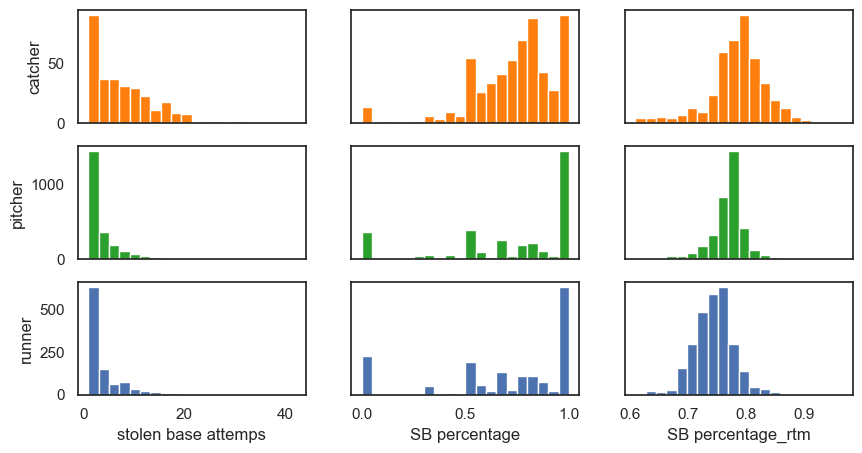

In [77]:
#print("Mean SB%: ", mean_success_rate)
print()
print("mean runner SB% before RTM:", round(runners_historical['SB_percent'].mean()*100,2))
print("mean pitcher SB% before RTM:", round(pitchers_historical['SB_percent'].mean()*100,2))
print("mean catcher SB% before RTM:", round(catchers_historical['SB_percent'].mean()*100,2))
print()
print("mean runner SB% after RTM:", round(runners_historical['runner_SB_percent_rtm'].mean()*100,2))
print("mean pitcher SB% after RTM:", round(pitchers_historical['pitcher_SB_percent_rtm'].mean()*100,2))
print("mean catcher SB% after RTM:", round(catchers_historical['catcher_SB_percent_rtm'].mean()*100, 2))


fig, axs = plt.subplots(3, 3, figsize = (10, 5))

axs[0,0].hist(catchers_historical['sb_attempts'], color='tab:orange', bins=20)
axs[0,1].hist(catchers_historical['SB_percent'], color='tab:orange', bins=20)
axs[0,2].hist(catchers_historical['catcher_SB_percent_rtm'], color='tab:orange', bins=20)
axs[1,0].hist(pitchers_historical['SB_attempt'], color='tab:green', bins=20)
axs[1,1].hist(pitchers_historical['SB_percent'], color='tab:green', bins=20)
axs[1,2].hist(pitchers_historical['pitcher_SB_percent_rtm'], color='tab:green', bins=20)
axs[2,0].hist(runners_historical['SB_attempt'], bins=20)
axs[2,1].hist(runners_historical['SB_percent'], bins=20)
axs[2,2].hist(runners_historical['runner_SB_percent_rtm'], bins=20)

axs[0,0].set(xlabel = 'percentage_rtm', ylabel = 'catcher')
axs[1,0].set(xlabel = 'percentage', ylabel = 'pitcher')
axs[2,0].set(xlabel = 'stolen base attemps', ylabel = 'runner')
axs[2,1].set(xlabel = 'SB percentage', ylabel = 'runner')
axs[2,2].set(xlabel = 'SB percentage_rtm', ylabel = 'runner')
    
for ax in axs.flat:
    ax.label_outer()

In [78]:
"""
steal_2b.drop(columns = ['catcher_SB_percent', 'catcher_SB_percent_rtm',
       'catcher_SB_attempts', 'Pitcher_Name', 'pitcher_SB_percent',
       'pitcher_SB_percent_rtm', 'pitcher_SB_attempts', 'runner_SB_percent',
       'runner_SB_percent_rtm', 'runner_SB_attemps'], inplace = True)
       
"""

"\nsteal_2b.drop(columns = ['catcher_SB_percent', 'catcher_SB_percent_rtm',\n       'catcher_SB_attempts', 'Pitcher_Name', 'pitcher_SB_percent',\n       'pitcher_SB_percent_rtm', 'pitcher_SB_attempts', 'runner_SB_percent',\n       'runner_SB_percent_rtm', 'runner_SB_attemps'], inplace = True)\n       \n"

In [79]:
# rename columns
catchers_historical.rename(columns= {'player_id': 'CatcherId',
                                    #'player_name': 'Catcher_Name',
                                    'SB_percent': 'catcher_SB_percent',
                                      'sb_attempts': 'catcher_SB_attempts'
                                    }, inplace = True)

pitchers_historical.rename(columns= {'player_id': 'PitcherId',
                                   # 'player_name': 'Pitcher_Name',
                                    'SB_percent': 'pitcher_SB_percent',
                                      'SB_attempt': 'pitcher_SB_attempts',
                                    'year': 'Year'}, inplace = True)

runners_historical.rename(columns= {#'pitchers_historical': 'CatcherId',
                                   # 'player_name': 'Pitcher_Name',
                                    'SB_percent': 'runner_SB_percent',
                                      'SB_attempt': 'runner_SB_attemps'}, inplace = True)


#merge them back to steal_2b
steal_2b = steal_2b.merge(catchers_historical[['CatcherId', 'Year',  'catcher_SB_percent', 'catcher_SB_percent_rtm', 'catcher_SB_attempts']], how = 'left', on = ['CatcherId', 'Year'])
steal_2b = steal_2b.merge(pitchers_historical[['PitcherId',  'Year','Pitcher_Name', 'pitcher_SB_percent', 'pitcher_SB_percent_rtm', 'pitcher_SB_attempts']], how = 'left', on = ['PitcherId', 'Year'])
steal_2b = steal_2b.merge(runners_historical[['StartRunnerOnFirstId',  'Year', 'runner_SB_percent', 'runner_SB_percent_rtm', 'runner_SB_attemps']], how = 'left', on = ['StartRunnerOnFirstId', 'Year'])


# fill in missing values with mean values from the population:
steal_2b['catcher_SB_percent_rtm'].fillna(steal_2b['catcher_SB_percent_rtm'].mean(), inplace = True)
steal_2b['catcher_SB_attempts'].fillna(steal_2b['catcher_SB_attempts'].mean(), inplace = True)
steal_2b['pitcher_SB_percent_rtm'].fillna(steal_2b['pitcher_SB_percent_rtm'].mean(), inplace = True)
steal_2b['pitcher_SB_attempts'].fillna(steal_2b['pitcher_SB_attempts'].mean(), inplace = True)

Add new historical stolcen base success rate features to features list:

In [80]:
# update features list
features_rtm =  ['catcher_SB_percent', 'catcher_SB_percent_rtm', 'catcher_SB_attempts',
                 'pitcher_SB_percent', 'pitcher_SB_percent_rtm', 'pitcher_SB_attempts', 
                 'runner_SB_percent',  'runner_SB_percent_rtm', 'runner_SB_attemps'] 
features_initial = features_initial + features_rtm

C:\Users\eniko\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\eniko\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 33.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\eniko\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 39.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\eniko\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 54.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\eniko\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 33.8% of the points

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'catcher_SB_percent'),
  Text(1, 0, 'catcher_SB_percent_rtm'),
  Text(2, 0, 'catcher_SB_attempts'),
  Text(3, 0, 'pitcher_SB_percent'),
  Text(4, 0, 'pitcher_SB_percent_rtm'),
  Text(5, 0, 'pitcher_SB_attempts'),
  Text(6, 0, 'runner_SB_percent'),
  Text(7, 0, 'runner_SB_percent_rtm'),
  Text(8, 0, 'runner_SB_attemps')])

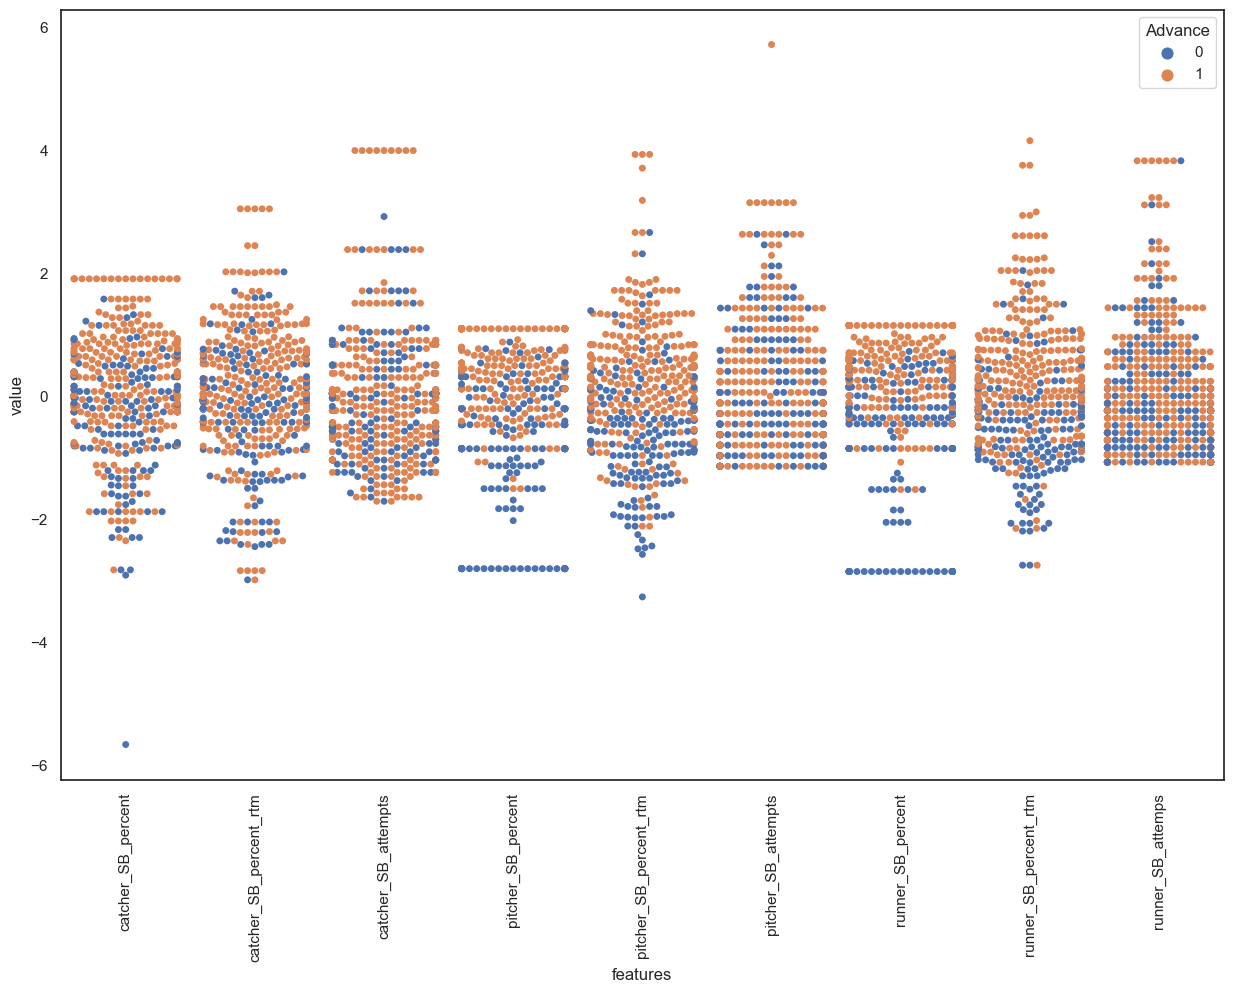

In [81]:
#Create swarmplot for new features
sample= steal_2b.sample(n= 500)
data = sample[features_rtm]
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([sample['Advance'] , data_n_2],axis=1)
data = pd.melt(data,id_vars="Advance",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(15, 10))
sns.swarmplot(x="features", y = "value", hue = "Advance", data =data)
plt.xticks(rotation=90)

Based on the above plot I would expect pitcher_SB_percent_rtm and runner_SB_percent_rtm to be the best classifier. 

# Final Feature Selection - Correlation
Correlation shows relationships between variables: first I look at correlations between Advance(SB flag) and other features then I check correlations between all features. I kept the non-regressed to the mean features for the charts just to check but will remove them. Based on the below chart pitcher_percentage_rtm, runner_percentage_rtm and Secondary_Lead_Distance has the highest corrlation with Stolen Base success.

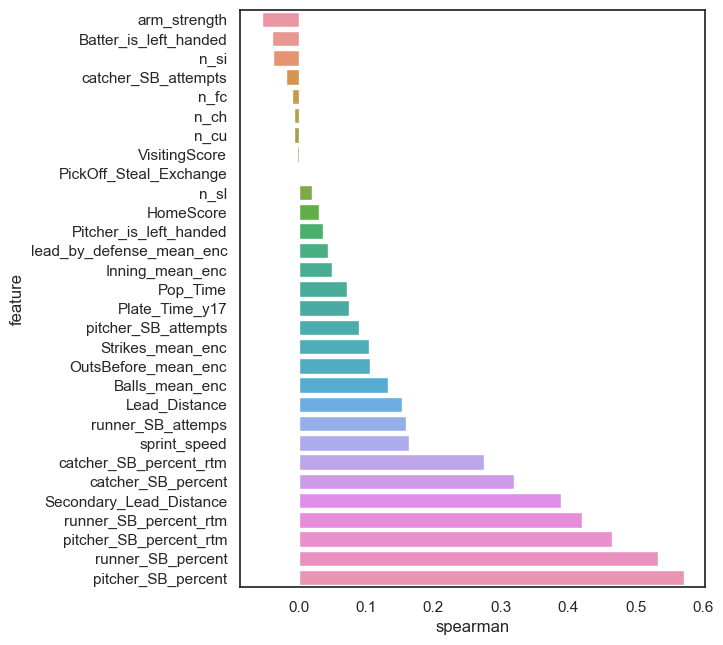

In [82]:
#correlation with Advance
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(steal_2b['Advance'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features_to_plot = features_initial.copy()
features_to_plot.remove('Advance')
features_to_plot.remove('ThrownOut')
spearman(steal_2b, features_to_plot)

<AxesSubplot:>

<Figure size 640x480 with 0 Axes>

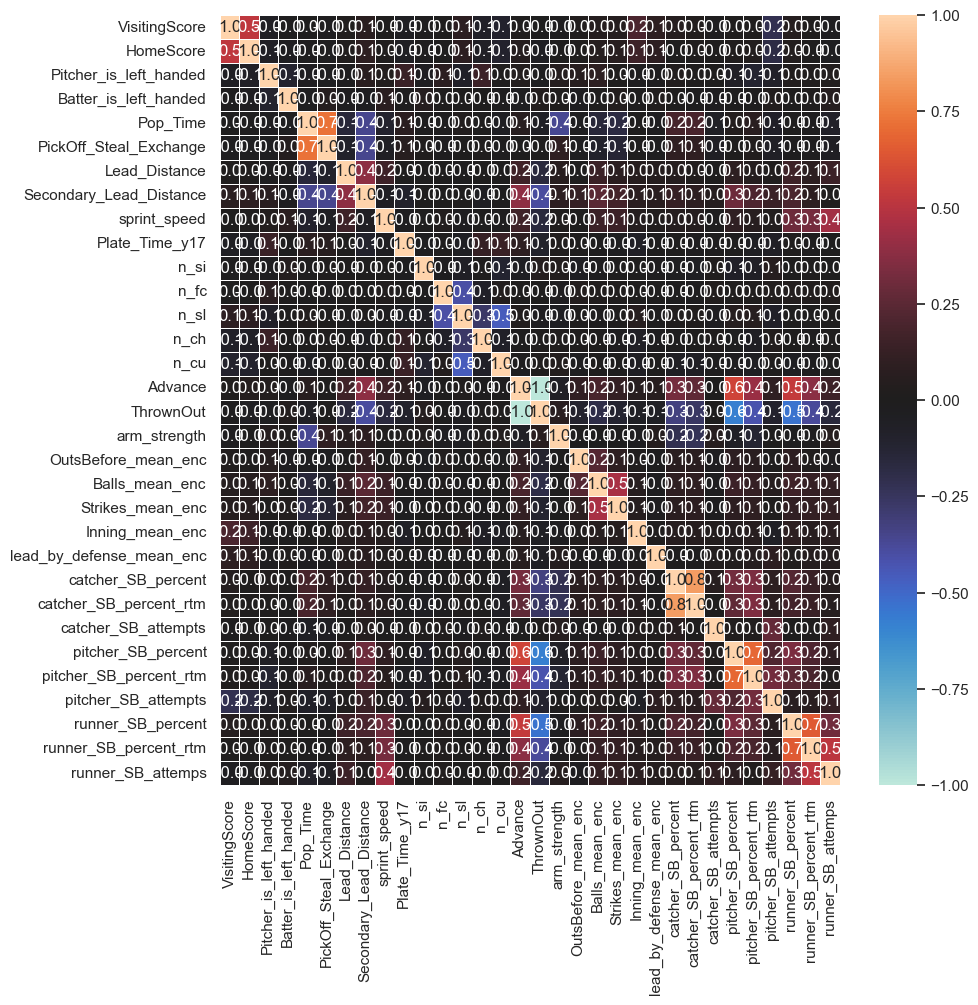

In [83]:
plt.figure(1)
plt.figure(figsize=(10,10))
corr = steal_2b[features_initial].corr()
sns.heatmap(corr, annot= True, linewidth = .5, fmt = '.1f', center = 0)

There are some strong correlations between variables. Historical percentages and regressed to the mean percentages correlates to each other. Also catcher_sba and pop_2b_sba_count have 1 correlation. 

I will remove the below features from final features list:

- Advance and ThrownOut are target variables
- pitcher_SB_percent, runner_SB_percent, catcher_SB_percent: since there are many players with one or a few attemps only I will use regressed to the mean features in the model not to overfit and get more generalized percentages for the players which are closer to their true talent.

In [84]:
#upate features list
for feature in [ 'catcher_SB_percent', #'catcher_SB_attempts', 
                'pitcher_SB_percent', # 'pitcher_SB_attempts', 
                'runner_SB_percent', #'runner_SB_attemps',
               'ThrownOut', 'Advance', 
                'VisitingScore', 'HomeScore']:
    features_initial.remove(feature)

<AxesSubplot:>

<Figure size 640x480 with 0 Axes>

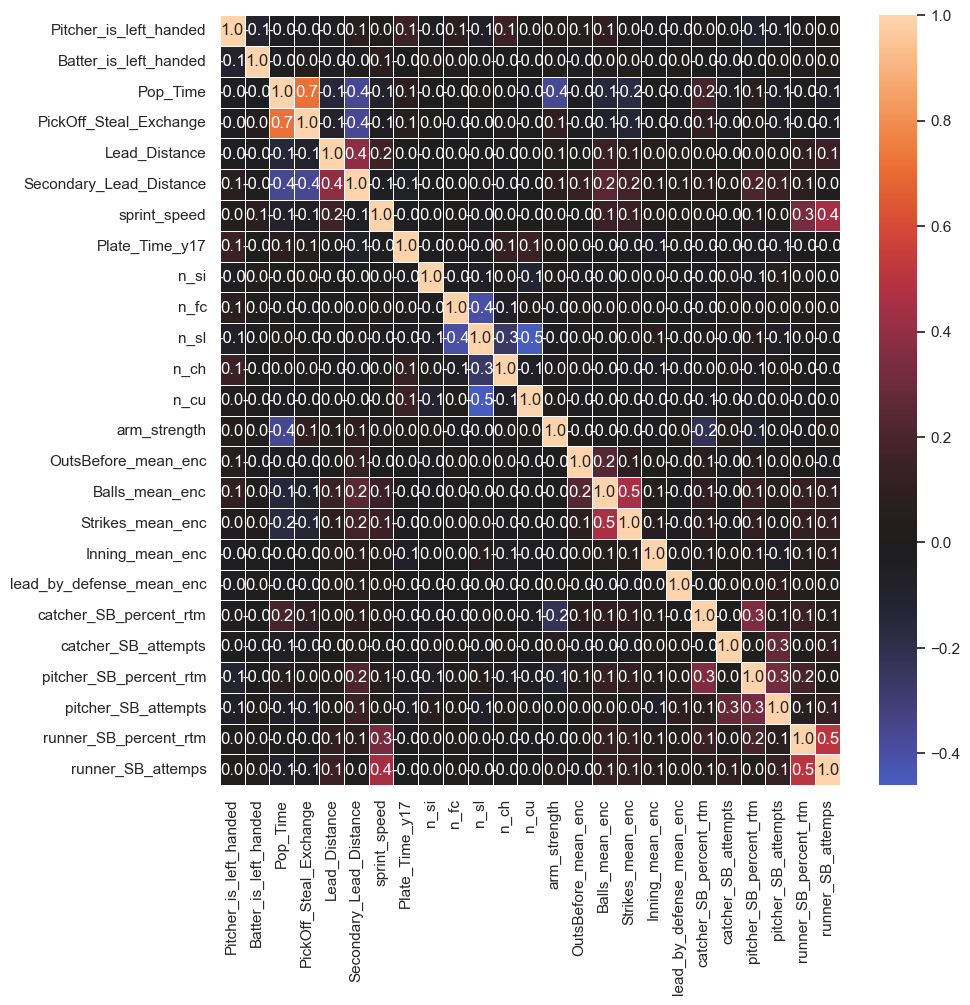

In [85]:
#final features correlation
plt.figure(1)
plt.figure(figsize=(10,10))
corr = steal_2b[features_initial].corr()
sns.heatmap(corr, annot= True, linewidth = .5, fmt = '.1f', center = 0)

## Save final df

In [72]:
steal_2b.to_excel('steal_2b_for_modeling.xlsx', index = False)

In [95]:
features_initial

['Pitcher_is_left_handed',
 'Batter_is_left_handed',
 'Pop_Time',
 'PickOff_Steal_Exchange',
 'Lead_Distance',
 'Secondary_Lead_Distance',
 'sprint_speed',
 'Plate_Time_y17',
 'n_si',
 'n_fc',
 'n_sl',
 'n_ch',
 'n_cu',
 'arm_strength',
 'OutsBefore_mean_enc',
 'Balls_mean_enc',
 'Strikes_mean_enc',
 'Inning_mean_enc',
 'lead_by_defense_mean_enc',
 'catcher_SB_percent_rtm',
 'catcher_SB_attempts',
 'pitcher_SB_percent_rtm',
 'pitcher_SB_attempts',
 'runner_SB_percent_rtm',
 'runner_SB_attemps']

# Modeling

In [96]:
# check missing values: 
missing_val_count_by_column = (steal_2b[features_initial].isna().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])
#features_initial.append('Advance')

Series([], dtype: int64)


In [97]:
print(len(steal_2b))
steal_2b_no_null = steal_2b[features_initial].dropna(how = 'any')
print(len(steal_2b_no_null))

3047
3047


# Train-Test split

In [98]:
# Establishing X and y
labels = steal_2b['Advance']
features = steal_2b[features_initial]#.drop(['Advance'], axis = 1)

#normalization
#features = (features - np.min(features)) / (np.max(features)- np.min(features)).values

#split into train and test data
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True)

# Standard scaling of the train and test data
r_ssX = StandardScaler()
features_train = pd.DataFrame(r_ssX.fit_transform(features_train), columns = features_train.columns)
features_test = pd.DataFrame(r_ssX.fit_transform(features_test), columns = features_test.columns)

print("features_train: " ,features_train.shape)
print("features_test: ", features_test.shape)
print("labels_train: ", labels_train.shape)
print("labels_test: ", labels_test.shape)

features_train:  (2132, 25)
features_test:  (915, 25)
labels_train:  (2132,)
labels_test:  (915,)


C:\Users\eniko\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\eniko\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Test data')

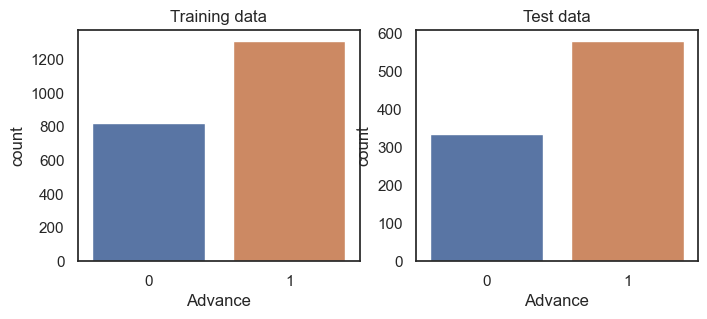

In [99]:
fig, ax = plt.subplots(1,2, figsize = (8, 3))
sns.countplot(labels_train, label="Count", ax=ax[0]).set_title("Training data")
sns.countplot(labels_test, label="Count", ax = ax[1]).set_title("Test data")

C:\Users\eniko\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Number of CS:  1160
Number of SB:  1887
Average Success Rate:  61.93 %


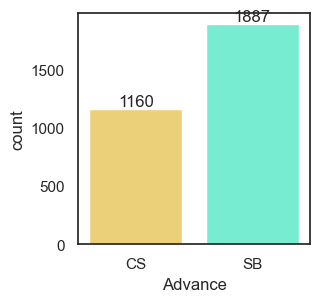

In [100]:
# for ppt presentation
#show number of SB (Advance = 1) and CS (Advance = 0)
plt.figure(figsize= (3,3))
ax=sns.countplot(pd.concat([labels_train, labels_test]).apply(lambda x: 'CS' if x == 0 else 'SB'), label="Count", 
                palette=['#FFD966',"#64ffda"])
ax.bar_label(ax.containers[0])
SB, CS = steal_2b["Advance"].value_counts()
print('Number of CS: ', CS)
print('Number of SB: ', SB)
print ('Average Success Rate: ' , round(SB/(CS+SB)*100, 2), '%')

# Model 1 - Only historical SB rates: 

In [101]:
features_train_m1 = features_train[['runner_SB_percent_rtm', 'pitcher_SB_percent_rtm', 'catcher_SB_percent_rtm']]
features_test_m1 = features_test[['runner_SB_percent_rtm', 'pitcher_SB_percent_rtm', 'catcher_SB_percent_rtm']] 

### Trying different classifiers:
First I try several classifiers on the training data with cross validation and see accuracy and f1 scores. Since the data is a unbalanced accuracy is not a good metric for evaluation. I could use precision, recall or f1-score. As a goal we could maximize the number of stolen bases (high recall) but in this case we can end up with too many outs, or minimize caught steals (high precision) but we could miss too many steal opportunities and lose some additional scores. To balance between the two cases I will use the F1-score for optimization.


In [105]:
try_classifiers(features_train_m1)

Model    Score       f1
2        Gradient Boosting  0.79502  0.83523
3            Random Forest  0.77626  0.83065
0  Support Vector Machines  0.77018  0.81596
1      Logistic Regression  0.75938  0.81125
6                  XGBoost  0.76500  0.80932
4              Naive Bayes  0.75750  0.80334
5            Decision Tree  0.70216  0.74949

Accurary: 0.7825136612021858
Accurary on train: 0.8048780487804879
f1 score: 0.832632464255677
logloss: 0.48151177780630355
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       336
           1       0.81      0.85      0.83       579

    accuracy                           0.78       915
   macro avg       0.77      0.76      0.76       915
weighted avg       0.78      0.78      0.78       915



<Figure size 100x100 with 0 Axes>

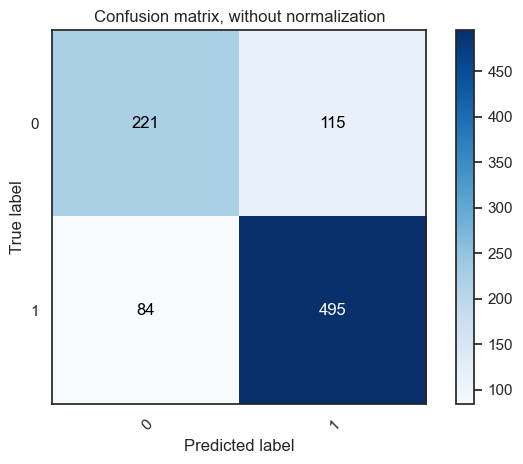

<Figure size 100x100 with 0 Axes>

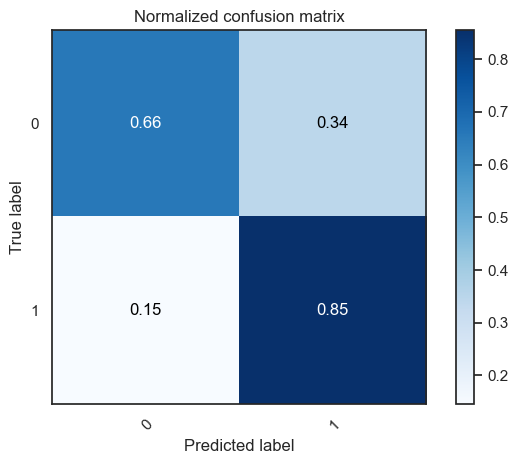

In [106]:
clf_m1= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model_evaluation(clf_m1, features_train_m1, features_test_m1)

In [107]:
# feature importances:
feature_imp = pd.Series(clf_m1.feature_importances_, index = features_train_m1.columns).sort_values(ascending = False)
feature_imp

pitcher_SB_percent_rtm    0.587882
runner_SB_percent_rtm     0.340776
catcher_SB_percent_rtm    0.071343
dtype: float64

<AxesSubplot:ylabel='Feature'>

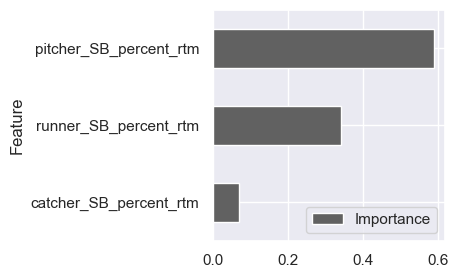

In [125]:
# for ppt presentation
# visual:
sns.set_style("darkgrid")
feature_importance = pd.DataFrame({'Feature': features_train_m1.columns, 'Importance': clf_m1.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending = True)

feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (3,3),   color = '#616161') #78909c

# Model 2 - only with inputs from original dataset:


In [109]:
features_train_m2 = features_train[['Pitcher_is_left_handed', 'Batter_is_left_handed', 'Pop_Time',
       'PickOff_Steal_Exchange', 'Lead_Distance', 'Secondary_Lead_Distance',
        'Plate_Time_y17', 'OutsBefore_mean_enc', 'Balls_mean_enc',
       'Strikes_mean_enc', 'Inning_mean_enc', 'lead_by_defense_mean_enc']]
features_test_m2 = features_test[['Pitcher_is_left_handed', 'Batter_is_left_handed', 'Pop_Time',
       'PickOff_Steal_Exchange', 'Lead_Distance', 'Secondary_Lead_Distance',
        'Plate_Time_y17', 'OutsBefore_mean_enc', 'Balls_mean_enc',
       'Strikes_mean_enc', 'Inning_mean_enc', 'lead_by_defense_mean_enc']] 

In [110]:
### Trying different classifiers:
try_classifiers(features_train_m2)

Model    Score       f1
1      Logistic Regression  0.72139  0.78547
0  Support Vector Machines  0.71154  0.77863
3            Random Forest  0.69090  0.77766
2        Gradient Boosting  0.71013  0.77326
4              Naive Bayes  0.68761  0.76830
6                  XGBoost  0.70589  0.76739
5            Decision Tree  0.63647  0.70299

Accurary: 0.726775956284153
Accurary on train: 0.725140712945591
f1 score: 0.7927031509121062
logloss: 0.533746106812835
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       336
           1       0.76      0.83      0.79       579

    accuracy                           0.73       915
   macro avg       0.71      0.69      0.70       915
weighted avg       0.72      0.73      0.72       915



<Figure size 100x100 with 0 Axes>

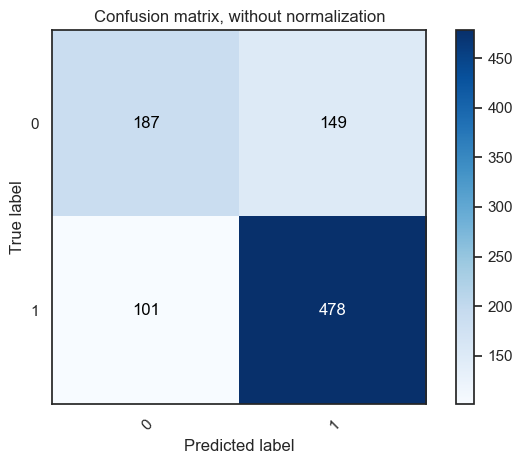

<Figure size 100x100 with 0 Axes>

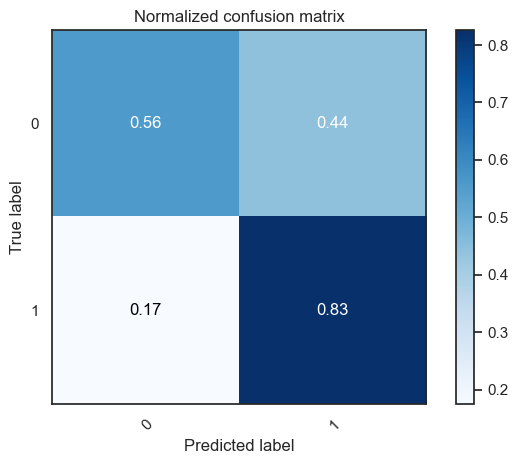

In [111]:
clf_m2= LogisticRegression(random_state= 42, solver = 'liblinear')
model_evaluation(clf_m2, features_train_m2, features_test_m2)

In [112]:
# feature importances:
coeff_df = pd.DataFrame(features_train_m2.columns) 
coeff_df.columns = ['Feature']
coeff_df["Importance"] = pd.Series(clf_m2.coef_[0])

coeff_df.sort_values(by='Importance', ascending=False, key=abs)

Feature  Importance
5    Secondary_Lead_Distance    1.235121
2                   Pop_Time    0.638578
6             Plate_Time_y17    0.334564
8             Balls_mean_enc    0.219976
11  lead_by_defense_mean_enc    0.137245
9           Strikes_mean_enc    0.108494
3     PickOff_Steal_Exchange    0.099760
7        OutsBefore_mean_enc    0.077352
1      Batter_is_left_handed   -0.070601
10           Inning_mean_enc    0.066134
4              Lead_Distance   -0.029836
0     Pitcher_is_left_handed   -0.013276

In [113]:
rfecv = RFECV(estimator=clf_m2, step=1, cv=5,scoring='f1')   #5-fold cross-validation
rfecv = rfecv.fit(features_train_m2, labels_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', features_train_m2.columns[rfecv.support_])

Optimal number of features : 7
Best features : Index(['Pop_Time', 'PickOff_Steal_Exchange', 'Secondary_Lead_Distance',
       'Plate_Time_y17', 'Balls_mean_enc', 'Strikes_mean_enc',
       'lead_by_defense_mean_enc'],
      dtype='object')


In [114]:
features_train_m2_rfe = features_train[['Pop_Time', 'PickOff_Steal_Exchange', 'Secondary_Lead_Distance',
       'Plate_Time_y17', 'Balls_mean_enc', 'Strikes_mean_enc',
       'lead_by_defense_mean_enc']]
features_test_m2_rfe = features_test[['Pop_Time', 'PickOff_Steal_Exchange', 'Secondary_Lead_Distance',
       'Plate_Time_y17', 'Balls_mean_enc', 'Strikes_mean_enc',
       'lead_by_defense_mean_enc']] 

Accurary: 0.7103825136612022
Accurary on train: 0.725140712945591
f1 score: 0.7808105872622001
logloss: 0.5337093065949481
              precision    recall  f1-score   support

           0       0.62      0.53      0.57       336
           1       0.75      0.82      0.78       579

    accuracy                           0.71       915
   macro avg       0.69      0.67      0.68       915
weighted avg       0.70      0.71      0.70       915



<Figure size 100x100 with 0 Axes>

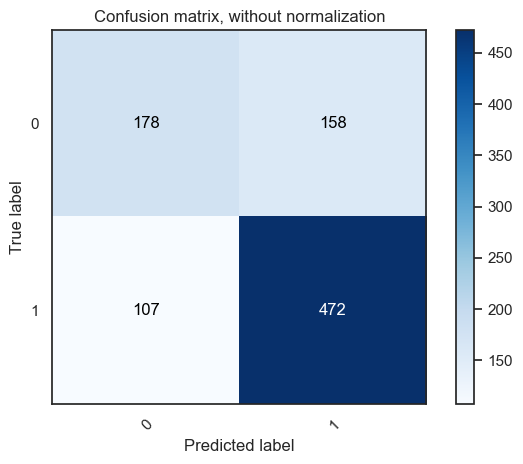

<Figure size 100x100 with 0 Axes>

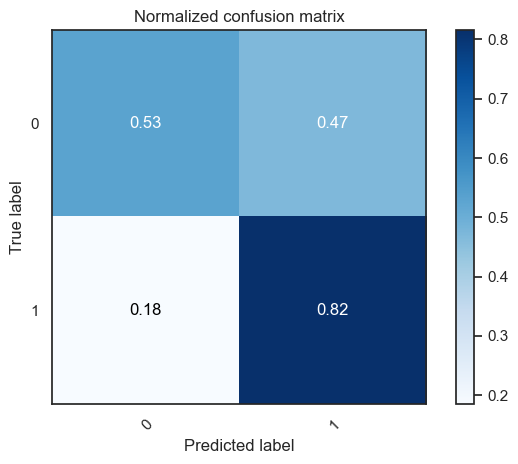

In [115]:
clf_m2_rfe= LogisticRegression(random_state= 42, solver = 'liblinear')
model_evaluation(clf_m2_rfe, features_train_m2_rfe, features_test_m2_rfe)

In [116]:
# feature importances:
coeff_df = pd.DataFrame(features_train_m2_rfe.columns) 
coeff_df.columns = ['Feature']
coeff_df["Importance"] = pd.Series(clf_m2_rfe.coef_[0])

coeff_df.sort_values(by='Importance', ascending=False, key=abs)

Feature  Importance
2   Secondary_Lead_Distance    1.235189
0                  Pop_Time    0.654305
3            Plate_Time_y17    0.328603
4            Balls_mean_enc    0.235522
6  lead_by_defense_mean_enc    0.134547
5          Strikes_mean_enc    0.110905
1    PickOff_Steal_Exchange    0.083218

<AxesSubplot:ylabel='Feature'>

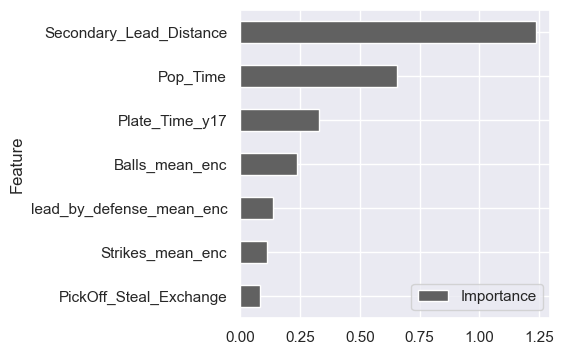

In [126]:
# visual:
coefficients = clf_m2_rfe.coef_[0]

feature_importance = pd.DataFrame({'Feature': features_train_m2_rfe.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending = True)

feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (4,4),  color = '#616161') #78909c

# Model 3 - All features

In [118]:
### Trying different classifiers:
try_classifiers(features_train)

Model    Score       f1
2        Gradient Boosting  0.83583  0.86835
6                  XGBoost  0.83723  0.86768
0  Support Vector Machines  0.81426  0.85124
1      Logistic Regression  0.80910  0.84688
3            Random Forest  0.80534  0.84374
4              Naive Bayes  0.77297  0.81768
5            Decision Tree  0.76595  0.80738

Accurary: 0.8240437158469945
Accurary on train: 0.8166041275797373
f1 score: 0.8620394173093401
logloss: 0.39357597795086935
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       336
           1       0.86      0.87      0.86       579

    accuracy                           0.82       915
   macro avg       0.81      0.81      0.81       915
weighted avg       0.82      0.82      0.82       915



<Figure size 100x100 with 0 Axes>

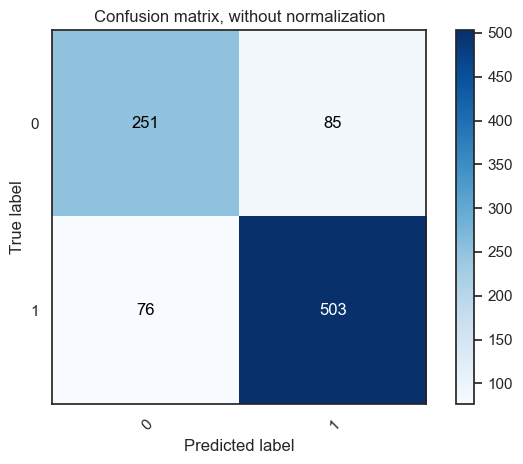

<Figure size 100x100 with 0 Axes>

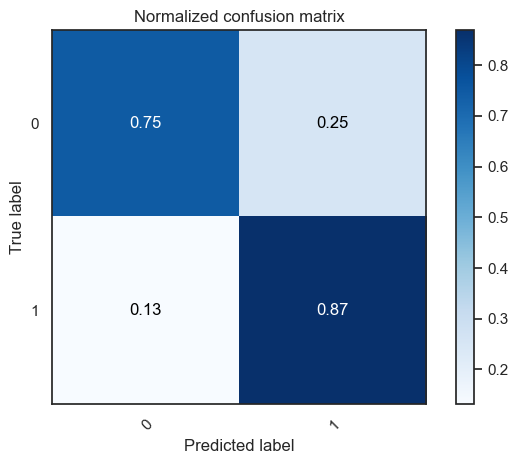

In [119]:
clf_m3= LogisticRegression(random_state= 42, solver = 'liblinear')
model_evaluation(clf_m3, features_train, features_test)

In [120]:
# feature importances:
coeff_df = pd.DataFrame(features_train.columns) 
coeff_df.columns = ['Feature']
coeff_df["Importance"] = pd.Series(clf_m3.coef_[0])

coeff_df.sort_values(by='Importance', ascending=False, key=abs)

Feature  Importance
5    Secondary_Lead_Distance    1.389794
23     runner_SB_percent_rtm    0.969728
21    pitcher_SB_percent_rtm    0.950492
2                   Pop_Time    0.679254
6               sprint_speed    0.426995
7             Plate_Time_y17    0.423039
19    catcher_SB_percent_rtm    0.237630
18  lead_by_defense_mean_enc    0.140862
15            Balls_mean_enc    0.130836
12                      n_cu    0.130061
4              Lead_Distance   -0.129521
24         runner_SB_attemps   -0.121793
10                      n_sl    0.100352
13              arm_strength    0.096379
1      Batter_is_left_handed   -0.092184
14       OutsBefore_mean_enc    0.087905
0     Pitcher_is_left_handed    0.039387
8                       n_si   -0.037543
20       catcher_SB_attempts    0.035329
22       pitcher_SB_attempts    0.020274
17           Inning_mean_enc   -0.020215
16          Strikes_mean_enc   -0.018380
3     PickOff_Steal_Exchange    0.012540
9                       n_fc   -0.003601
11                      n_ch   -0.002540

#### RFE
Recursive Feature Elimination

In [121]:
rfecv = RFECV(estimator=clf_m3, step=1, cv=5,scoring='f1')   #5-fold cross-validation
rfecv = rfecv.fit(features_train, labels_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', features_train.columns[rfecv.support_])

Optimal number of features : 6
Best features : Index(['Pop_Time', 'Secondary_Lead_Distance', 'sprint_speed', 'Plate_Time_y17',
       'pitcher_SB_percent_rtm', 'runner_SB_percent_rtm'],
      dtype='object')


#### New model with best features:

Accurary: 0.8153005464480875
Accurary on train: 0.8194183864915572
f1 score: 0.8546861564918314
logloss: 0.38931691554875414
              precision    recall  f1-score   support

           0       0.75      0.74      0.75       336
           1       0.85      0.86      0.85       579

    accuracy                           0.82       915
   macro avg       0.80      0.80      0.80       915
weighted avg       0.81      0.82      0.82       915



<Figure size 100x100 with 0 Axes>

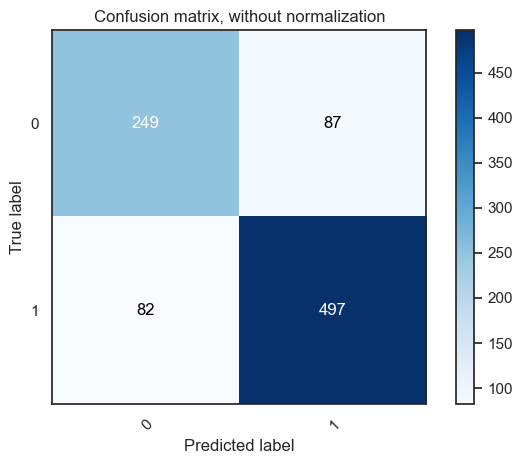

<Figure size 100x100 with 0 Axes>

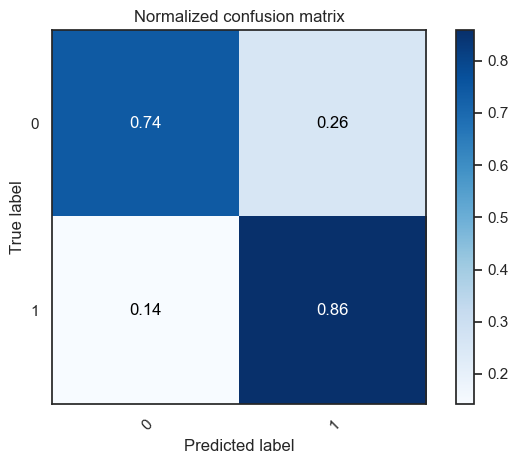

In [122]:
features_train_rfe = features_train[['Pop_Time', 'Secondary_Lead_Distance', 'sprint_speed', 'Plate_Time_y17',
       'pitcher_SB_percent_rtm', 'runner_SB_percent_rtm']]
features_test_rfe = features_test[['Pop_Time', 'Secondary_Lead_Distance', 'sprint_speed', 'Plate_Time_y17',
       'pitcher_SB_percent_rtm', 'runner_SB_percent_rtm']] 

clf_m3_rfe= LogisticRegression(random_state= 42, solver = 'liblinear')
model_evaluation(clf_m3_rfe, features_train_rfe, features_test_rfe)

## Feature importance
The most important features are Secondary_Lead_Distance, pitcher_SB_percent_rtm and runner_SB_percent_rtm which are the historical stolen base success rates against the pitchers and for the runners.

In [123]:
# feature importances:
coeff_df = pd.DataFrame(features_train_rfe.columns) 
coeff_df.columns = ['Feature']
coeff_df["Importance"] = pd.Series(clf_m3_rfe.coef_[0])
coeff_df = coeff_df.sort_values('Importance', ascending = False).reset_index(drop = True)

coeff_df.sort_values(by='Importance', ascending=False, key=abs)

Feature  Importance
0  Secondary_Lead_Distance    1.390967
1   pitcher_SB_percent_rtm    1.036368
2    runner_SB_percent_rtm    0.922353
3                 Pop_Time    0.682202
4           Plate_Time_y17    0.439806
5             sprint_speed    0.366112

<AxesSubplot:ylabel='Feature'>

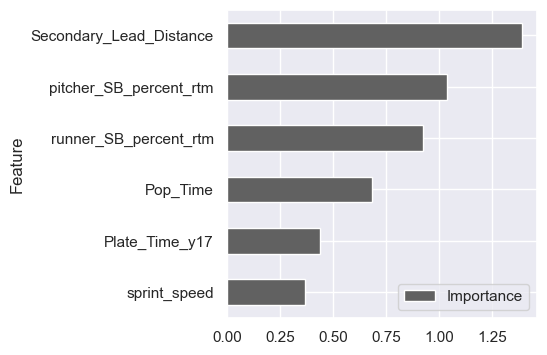

In [124]:
# visual:
sns.set_style("darkgrid")
coefficients = clf_m3_rfe.coef_[0]

feature_importance = pd.DataFrame({'Feature': features_train_rfe.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending = True)

feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (4,4), color = '#616161'  ) #'#78909c'

Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

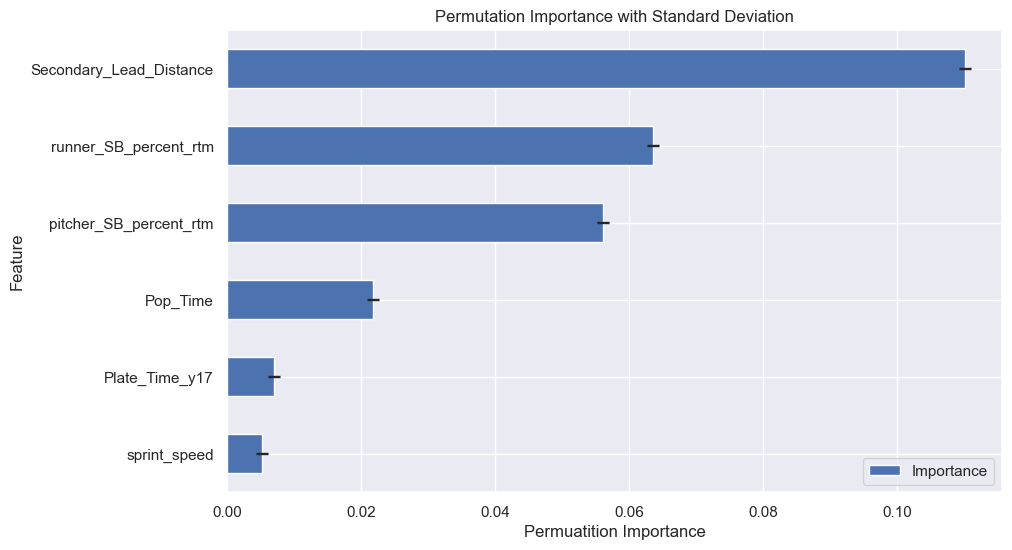

In [127]:
#permutation importance
from sklearn.inspection import permutation_importance
result = permutation_importance(clf_m3_rfe, features_test_rfe, labels_test, n_repeats = 10, random_state = 42)
feature_importance = pd.DataFrame({'Feature': features_train_rfe.columns,
                                  'Importance': result.importances_mean,
                                  'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending = True)

ax = feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (10,6), yerr= 'Standard Deviation', capsize = 4)
ax.set_xlabel('Permuatition Importance')
ax.set_title('Permutation Importance with Standard Deviation')

## Visualization
Now that we have the predicted values for stolen base attempts both the training and test set, I perform a quick evaluation on the training set by plotting the probability estimated by the model with a double density plot.

We want the model to give high scores to steals (1) and low scores to caught steals (0). The ideal double density function should be separated for the two classes: caught steals on the left and steals on the right.

In [128]:
# final model:
clf = clf_m3_rfe
pred = clf.predict(features_test_rfe)
proba = clf.predict_proba(features_test_rfe)
proba = proba[:,1]


C:\Users\eniko\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\eniko\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='prediction', ylabel='Density'>

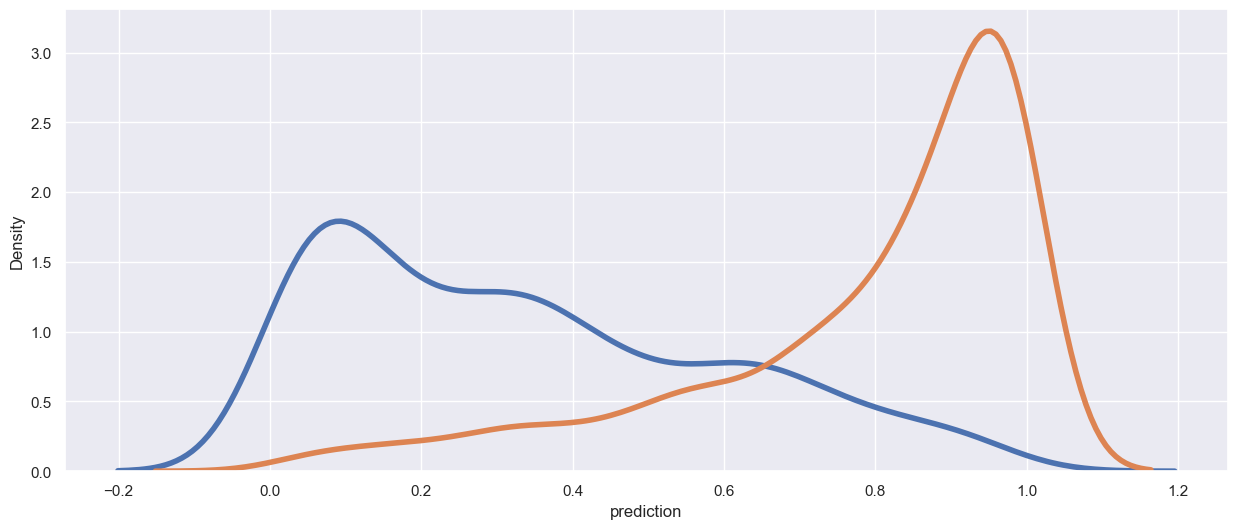

In [130]:
proba_train = clf.predict_proba(features_train_rfe)[:,1]
data_for_kde = pd.DataFrame(labels_train)
data_for_kde['prediction'] = proba_train

sns.set(rc={'figure.figsize' : (15,6)})
sns.distplot(data_for_kde[data_for_kde['Advance'] == 0]['prediction'], hist = False, kde = True, kde_kws = {'linewidth': 4}, label = "1")

sns.distplot(data_for_kde[data_for_kde['Advance'] == 1]['prediction'], hist = False, kde = True, kde_kws = {'linewidth': 4},  label = "0")

In my model, the distributions shows a good separation between stolen bases and caught steals. The probabilities for SB are predicted high but there are some probabilities for CSs that are higher than should be.

Since the prediction of a logistic regression model is a probability, in order to use it as a classifier, we’ll have to choose a cutoff value, where scores above this value will be classified as positive (SB), those below as negative (CS).

I will visualize the confusion matrix of the test set with 0.5 cutoff value (probabilities larger than 0.5 will be categorized as SB and lower will be CS). The predicted scores are jittered along their label (along the 0-CS and 1-SB) to make it more clear.

<AxesSubplot:xlabel='Advance', ylabel='prediction_prob'>

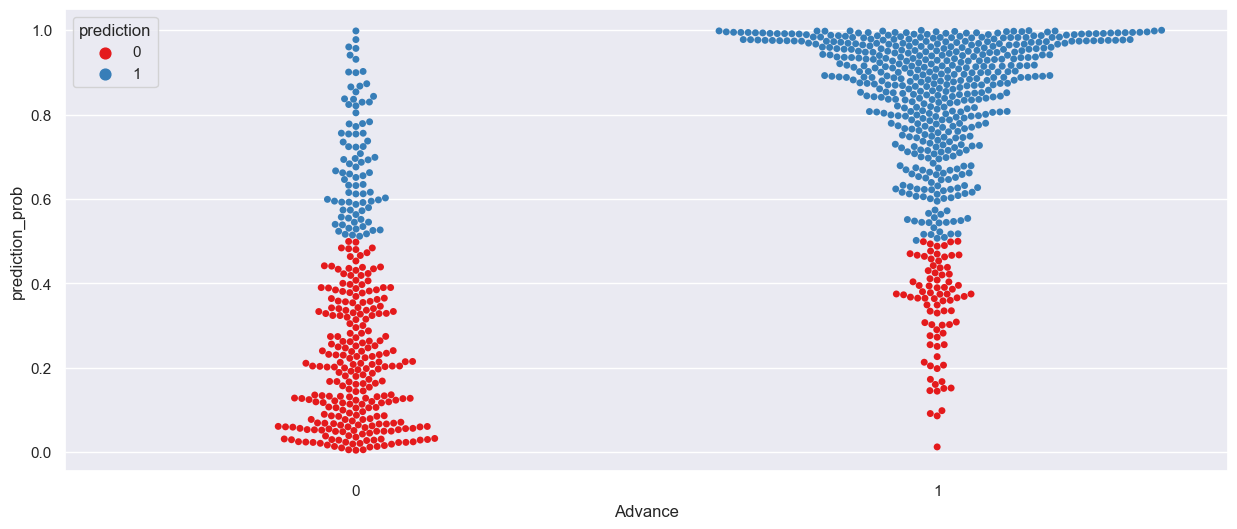

In [131]:
data_for_cm_plot = pd.DataFrame(labels_test)
data_for_cm_plot['prediction_prob'] = proba
data_for_cm_plot['prediction'] = pred

sns.swarmplot(x="Advance", y="prediction_prob",  data=data_for_cm_plot, hue="prediction" , palette = 'Set1') 

#### Visuals for ppt presentation:

C:\Users\eniko\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Advance', ylabel='prediction_probability'>

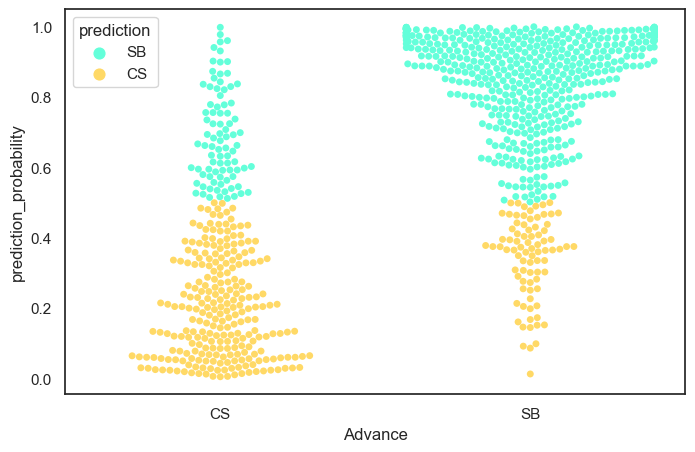

In [132]:
# for ppt presentation
# same visual
dct = {1:'SB', 0:'CS'}
labels_test_SB = [dct[k] for k in labels_test]
pred_SB = [dct[k] for k in pred]


data_for_cm_plot = pd.DataFrame(labels_test.apply(lambda x: 'CS' if x == 0 else 'SB'))
data_for_cm_plot['prediction_probability'] = proba
data_for_cm_plot['prediction'] = pred_SB

plt.figure(figsize=(8,5))
sns.set(style = "white")
sns.swarmplot(x="Advance", y="prediction_probability",  data=data_for_cm_plot, hue="prediction" ,  order = ['CS', 'SB'], palette=["#64ffda", '#FFD966']) 

[Text(0.5, 0, 'CS'), Text(1.5, 0, 'SB')]

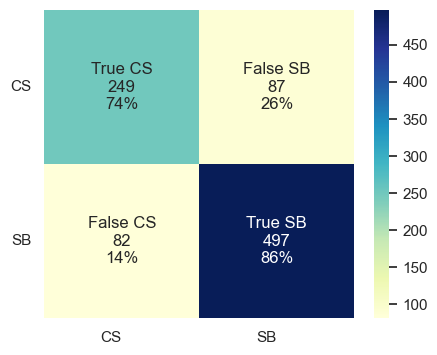

In [133]:
cf_matrix = confusion_matrix(labels_test.apply(lambda x: 'CS' if x == 0 else 'SB'), pred_SB)

group_names = ['True CS','False SB','False CS','True SB']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
group_percentages = ["{0:0.0%}".format(value) for value in
                     cf_matrix_norm.flatten()]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(5,4))
heatmap = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(['CS', 'SB'], rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(['CS', 'SB'], rotation=0, ha='right')

Based on the above the optimal cutoff is somewhere around 0.5.

## ROC Curve to choose optimal cutoff

Here I visualize the ROC curve. When we choose the cutoff value we make a balance between false positive and false negative rate. ROC curve visualize the tradeoff between the two measures.

AUC: 0.8983
Optimal threshold: 0.6005059658255792
cm: [[279  57]
 [107 472]]
Accurary: 0.8207650273224044
Accurary on train: 0.8194183864915572
f1 score: 0.8519855595667869
logloss: 0.38931691554875414
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       336
           1       0.89      0.82      0.85       579

    accuracy                           0.82       915
   macro avg       0.81      0.82      0.81       915
weighted avg       0.83      0.82      0.82       915



<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

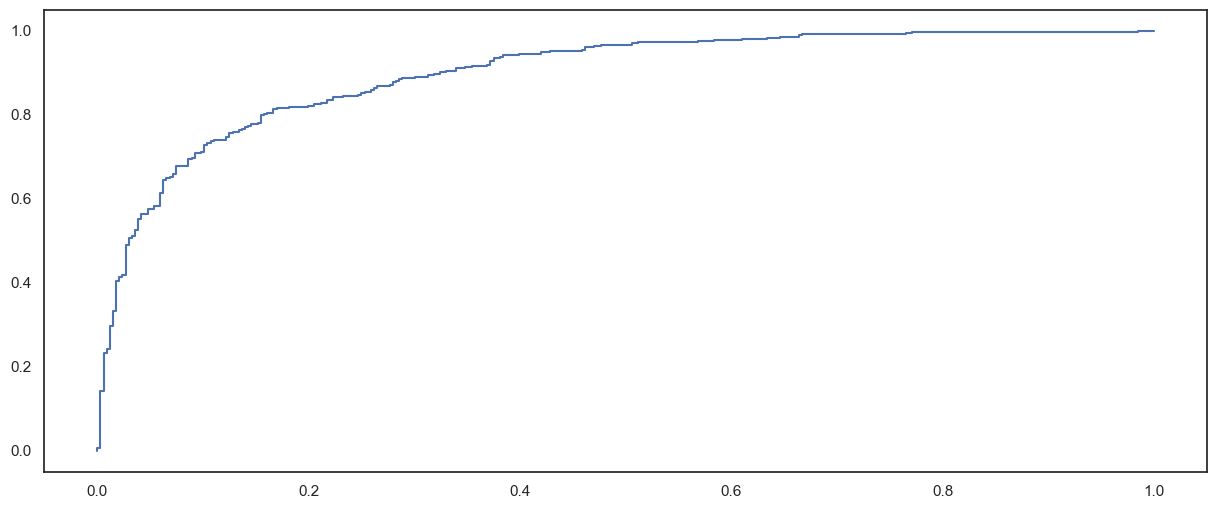

<Figure size 100x100 with 0 Axes>

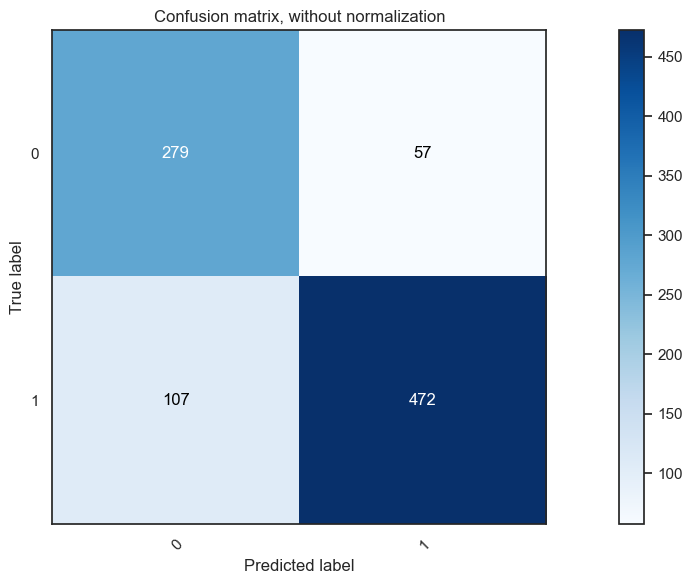

In [135]:
fpr, tpr, thr = roc_curve(labels_test, proba)
plt.plot(fpr, tpr)
print(f'AUC: {np.round(roc_auc_score(labels_test, proba), 4)}')

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thr[optimal_idx]
print ("Optimal threshold:" , optimal_threshold)

predicted = [1 if i > optimal_threshold else 0 for i in proba]
cm_2 = confusion_matrix(labels_test, predicted)
print ("cm:", cm_2)
print("Accurary:" , accuracy_score(labels_test, predicted))
print("Accurary on train:" , accuracy_score(labels_train, clf.predict(features_train_rfe)))
print( "f1 score:" , f1_score( labels_test, predicted))
print("logloss:", log_loss(labels_test, proba))

print(classification_report(labels_test,predicted))

classes = steal_2b.Advance #[CS, SB]
plot_confusion_matrix(labels_test, predicted, classes,
                          normalize=False)

max f1-score: 0.86810551558753
max accuracy: 0.8218579234972677


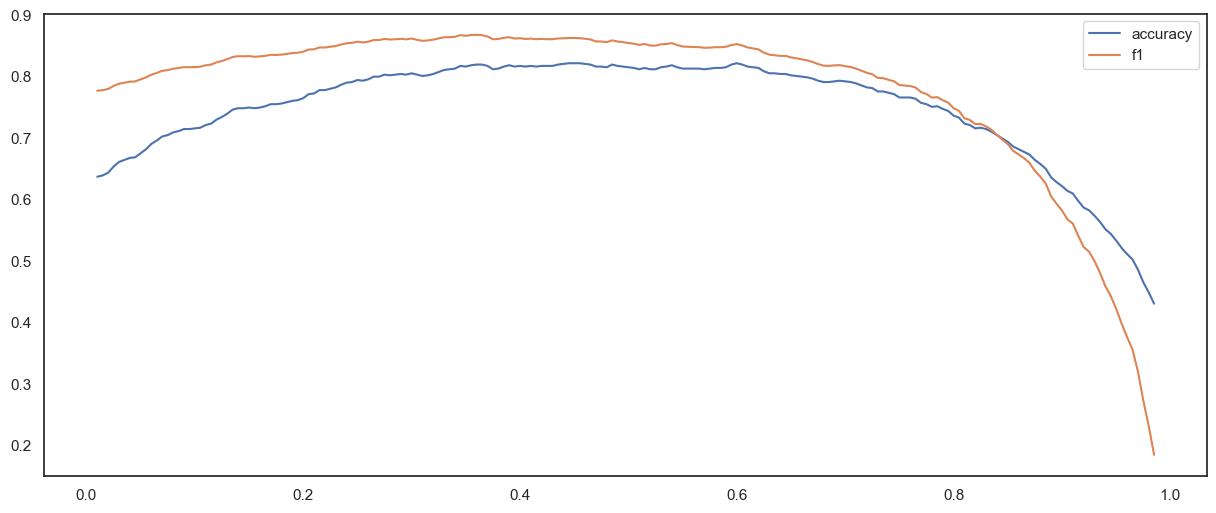

In [136]:
#optimal threshold by max accuracy, max f1
threshold= []
f1_score_th = []
acc_th = []
log_loss_th = []
for x in np.arange( 0.01, 0.99, 0.005):
    predicted = [1 if i > x else 0 for i in proba]
    #cm_2 = confusion_matrix(labels_test, predicted)
    
    threshold.append(x)
    f1_score_th.append(f1_score( labels_test, predicted ))#, average = 'weighted'))
    acc_th.append(accuracy_score(labels_test, predicted))
    
    
print("max f1-score:", max(f1_score_th))
    
print("max accuracy:", max(acc_th))

plt.plot(threshold, acc_th, label = "accuracy")
plt.legend()
plt.plot(threshold, f1_score_th, label = "f1")
plt.legend()

## Learning Curve

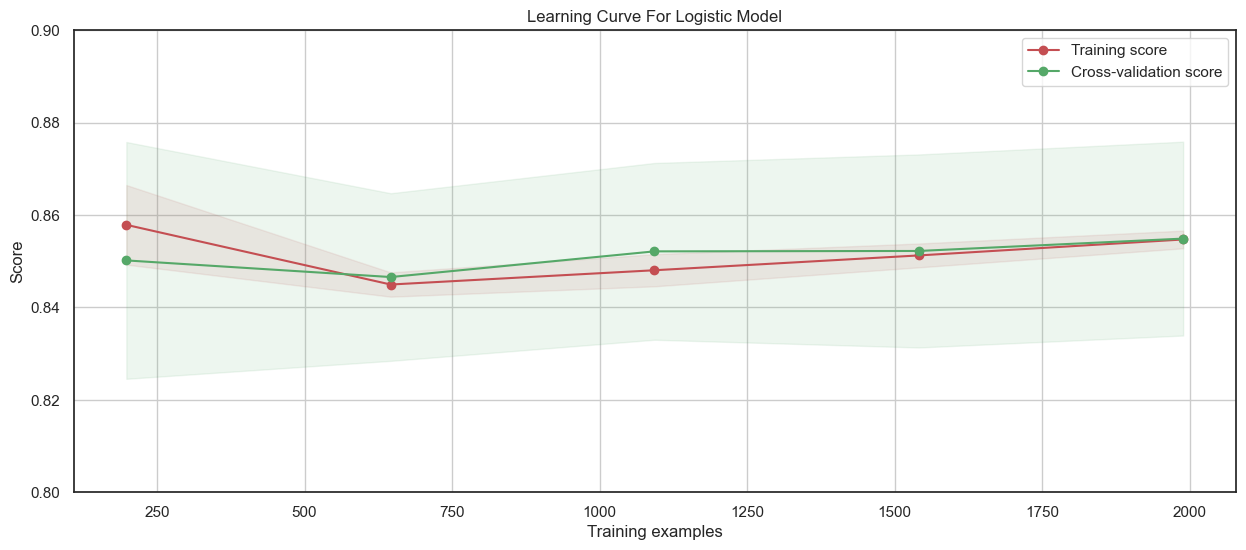

In [137]:
#Learning curve 
plot_learning_curve(clf_m3_rfe, 'Learning Curve For Logistic Model', features_train_rfe, labels_train, (0.8, 0.9), 15)
plt.savefig('7')
plt.show()

Based on the learning curve there might be little to learn. In this case even a small sample size can allow the model to find all detectable patterns, resulting in an early "high" score. If not all patterns can be detected, no perfect score can be achieved. Adding more features or polynomials could possibly increase scores. 

# Save output to csv

In [422]:

final_data = features_test
final_data['label_real'] = labels_test
final_data['label_predicted'] = pred
final_data['log_likelihood_elements'] = -log_likelihood_elements
final_data['probablity'] = proba

# save data to csv
file_name = 'prediction.csv'
final_data.to_csv(file_name)

# Next Steps 

#### Adding features
To improve the model we would need other features to be added which have more predictive power in deciding whether it is a stolen base or a caught steal. There are some information which would be very useful for the baserunner to know but not available at the time when the decision has to be made. These are for example the pitch type, location or pitch speed. We can add features to the model which have similar information but available beforehand: the hitter's plate discipline could help to guess the location. First pitch strike percentage can be useful too as seen earlier. The hitter's wOBA could probably improve the model as well (the pitcher and catcher are more focused on getting the hitter out if a better hitter is up increasing the chance for successful stolen base for the runner).

#### Adding more situations
In this model I focused on the cases when there is only one runner on first base and there is a steal attempt. The model could be extended to handle multiple base runners and pickoff events.